# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
pip install -U matplotlib

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     |████████████████████████████████| 11.2 MB 18.5 MB/s            
     |████████████████████████████████| 890 kB 70.4 MB/s            
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.4
    Uninstalling matplotlib-3.3.4:
      Successfully uninstalled matplotlib-3.3.4
Note: you may need to restart the kernel to use updated packages.


## Auto Reload Modules 
configure auto-reload of modules when they have been changed - this simplifies developing and testing

In [2]:
%load_ext autoreload
%autoreload 2

## Imports and global configs

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# magic word for producing visualizations in notebook
%matplotlib inline
sns.set_theme()

# display the N columns and rows
pd.set_option('display.max_columns', 50)

pd.set_option('display.max_rows', 100)

# set numpy printoptions
np.set_printoptions(threshold=500)

Table of Contents and Approach
---
1. [Data Exploration and Cleaning](#data-exploration-and-cleaning)
    1. Data loading and exploration
    1. Data cleaning and pre-processing
1. [Part 1: Customer Segmentation Report](#part_1:_customer_cegmentation_report)
    1. Dimensionality reduction with PCA
    1. Feature engineering and data transformation
    1. Clustering transformed data with k-means
    1. Extracting trained model attributes and visualizing k clusters


# Download Data
---
The four data sets
- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).
    
and two files of description    
- `DIAS Attributes - Values 2017.xlsx`
- `DIAS Information Levels - Attributes 2017.xlsx`

can be downloaded from the Udacity project workspace.

# Data exploration and cleaning
---

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

## Load Data from S3
The load script assumes that the downloaded data has been transferred to S3 or is available in the local /data directory.

The data load of the AZDIAS data set takes more than a minute the CUSTOMERS data set should be loaded in less than 20 secs


In [4]:
import os
if os.path.exists('data') and os.path.isdir('data'):
    prefix = './data'
else:
    prefix = 's3://sagemaker-eu-central-1-292575554790/dsnd_arvato'

In [5]:
%%time
df_azdias = pd.read_csv(f'{prefix}/Udacity_AZDIAS_052018.csv', sep=';', index_col='LNR')


/home/ec2-user/anaconda3/envs/mxnet_latest_p37/lib/python3.7/site-packages/IPython/core/magics/execution.py:1324: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code, glob, local_ns)


CPU times: user 23.7 s, sys: 4.06 s, total: 27.7 s
Wall time: 27.9 s


In [6]:
%%time
df_customers = pd.read_csv(f'{prefix}/Udacity_CUSTOMERS_052018.csv', sep=';', index_col='LNR')

CPU times: user 5.15 s, sys: 256 ms, total: 5.41 s
Wall time: 5.41 s


In [7]:
df_azdias.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,...,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,1.0,1.0,5.0,5.0,...,4,7,2,3,1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,8A,8.0,51.0,5.0,1.0,5.0,5.0,2.0,3.0,...,6,4,5,6,1,3,1.0,2.0,0.0,3.0,3.0,1.0,0.0,2,0.0,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,4C,4.0,24.0,3.0,2.0,4.0,4.0,1.0,3.0,...,4,3,4,3,4,2,0.0,3.0,0.0,2.0,5.0,0.0,1.0,1,0.0,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,2A,2.0,12.0,2.0,3.0,2.0,2.0,4.0,4.0,...,3,2,5,4,4,1,0.0,1.0,0.0,4.0,5.0,0.0,0.0,1,1.0,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,6B,6.0,43.0,5.0,3.0,3.0,3.0,3.0,4.0,...,2,4,6,2,7,2,0.0,3.0,0.0,4.0,3.0,0.0,1.0,2,0.0,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [8]:
df_azdias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891221 entries, 910215 to 825787
Columns: 365 entries, AGER_TYP to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(92), object(6)
memory usage: 2.4+ GB


In [9]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191652 entries, 9626 to 148883
Columns: 368 entries, AGER_TYP to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(8)
memory usage: 539.5+ MB


### Data errors during load
during the load process we got two error messages for columns 18 and 19. I will check this here

In [ ]:
df_azdias.columns[17:19]

In [ ]:
# column 18 has 0-based index 17
df_azdias.iloc[:,17].unique()

In [ ]:
# column 19 has 0-based index 18
df_customers.iloc[:,18].unique()

**Result:** The errors is caused by string values "X" and "XX" in the datasets in columns CAMEO_DEUG_2015 and CAMEO_INTL_2015.

I will add some code to the Data Cleaner class to handle this


## Data Exploration

### Step 1 - Metatadata exploration

In [ ]:
# Load the metadata into dataframe
df_metadata = pd.read_excel(f'{prefix}/DIAS Attributes - Values 2017.xlsx', usecols='B:E', dtype='str', header=1).fillna(method='ffill')
df_metadata.head()

In [ ]:
# are there NULLs in the dataset?
df_metadata.isnull().sum()

In [ ]:
print(f"Number of unique attributes: {df_metadata['Attribute'].unique().shape[0]}")
print(f"Number of Attributes that can be \'unnkown\' value: {df_metadata['Meaning'].str.contains('unknown').sum()}")
print(f"Number of Attributes that can be `no transaction known` value: {df_metadata['Meaning'].str.contains('no transaction.? known', regex=True).sum()}")
print(f"Total Metadata attributes considered as \'unknown\': {df_metadata['Meaning'].str.contains('unknown').sum() + df_metadata['Meaning'].str.contains('no transaction.? known', regex=True).sum()}")

In [ ]:
df_metadata[df_metadata['Meaning'].str.contains('no transaction.? known', regex=True)]

#### Metadata Summary

The value **"unkown"** will be treated like a missing value.

The value **"no transaction(s) known"** will be treated as if the customer has done no transaction



### Step 2- Check for duplicates in Population and Customer dataset
check if dataset contains duplicate records 
1. based on column ID LNR and 
1. based on identical records  (same values for all features)

In [ ]:
df_azdias.index.duplicated().sum()

In [ ]:
df_azdias.index.duplicated().sum()

In [ ]:
t1=df_azdias.drop_duplicates()
delta1 = df_azdias.shape[0] -t1.shape[0]

In [ ]:
delta1/df_azdias.shape[0]

**Result**: 5.1% of records in the df_azdias dataset are identical

In [ ]:
t2=df_customers.drop_duplicates()
delta2 = df_customers.shape[0] -t2.shape[0]

In [ ]:
delta2/df_customers.shape[0]

**Result**: 21.5% of records in the df_customers dataset are identical

### Step 3 - Compare features (columns) of population and customer datasets

Are the features the same?

Do both sets have same number of features?

Does Metadata dataset describe all colums?

In [ ]:
# columns that customers dataset contain but azidas not
set(df_customers.columns) - set(df_azdias.columns)

In [ ]:
# columns that azdias dataset contain but customers not
set(df_azdias.columns) - set(df_customers.columns)

**Result**: `CUSTOMERS` dataset has 3 more columns {'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

### Metadata Columns compared to Dataset columns

check for which columns of the dataset a metadata description exists

In [ ]:
df_metadata_cols = df_metadata['Attribute'].copy()
# some columns of the metadata ends on _RZ whereas the datasets have the same columns whcih do not end on _RZ
# therefore we replace this
df_metadata_cols = df_metadata_cols.str.replace('_RZ','')

diff_set = set(df_azdias.columns) - set(df_metadata_cols)
print(f'number of cols in AZDIAS dataset but not described in Metadata: {len(diff_set)}')
pd.Series(list(diff_set)).sort_values().unique()

In [ ]:
diff_set2 = set(df_metadata_cols) - set(df_azdias.columns)
print(f'number of cols in Metadata but not in AZDIAS dataset: {len(diff_set2)}')
diff_set2

#### View features that are not descirbed by Metdata

In [ ]:
df_azdias[list(diff_set)].head()

### Step 4 - Used Value 
some checks to see which values have been used and if they match the values defined in Metadata dataset. I will run several times the investigate_values to check which columns contain values that have to be corrected


In [ ]:
df_metadata['Value'].unique()

In [ ]:
df_metadata[df_metadata['Value']=='…']

#### Code Block
The function `investgate_values` extracts the different values that have been used

In [ ]:
# function to investigate column values
def investigate_values(values_to_find=[], cols_to_ignore=[]):
    value_set = set()
    cols_matching_search = []
    for col in df_azdias.columns:    
            if not col in cols_to_ignore:
                col_set = set(df_azdias[col].unique())        
                if any(val in values_to_find for val in col_set):
                    print(col)
                    cols_matching_search.append(col)
                value_set = value_set | col_set
            
    return value_set, cols_matching_search


In [ ]:
vs, cols = investigate_values(cols_to_ignore=['EINGEFUEGT_AM'])
vals = np.array(list(vs))
vals[vals!='nan'][:200]

**Result**: There are several floats that have not been described in the metadata - let's find out whicht columns contain that values.

In order to identify the columns that contains these values we checks step yb step which values are in which columns

In [ ]:
# Step 1 check for values 86.0, 91.0
vs, cols = investigate_values([86.0,91.0],cols_to_ignore=['EINGEFUEGT_AM'])
np.array(list(vs))[:100]

In [ ]:
# Step 2 check for 
vs, cols = investigate_values(cols_to_ignore=['ANZ_HAUSHALTE_AKTIV','ANZ_STATISTISCHE_HAUSHALTE','KBA13_ANZAHL_PKW','EINGEFUEGT_AM'])
vals = np.array(list(vs))
vals[vals!='nan']

In [ ]:
vs, cols = investigate_values(['D19_LEBENSMITTEL', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV',
 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KOSMETIK', 'D19_LEBENSMITTEL', 'D19_LOTTO', 'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER',
 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE', 'D19_TECHNIK', 'D19_TELKO_MOBILE', 'D19_TELKO_REST', 'D19_TIERARTIKEL', 'D19_UNBEKANNT', 'D19_VERSAND_REST', 'D19_VERSICHERUNGEN', 'D19_VOLLSORTIMENT', 'D19_WEIN_FEINKOST', 1939, 2001,2001.0,2000.0],cols_to_ignore=['ANZ_HAUSHALTE_AKTIV','ANZ_STATISTISCHE_HAUSHALTE','KBA13_ANZAHL_PKW','EINGEFUEGT_AM'])
vals = np.array(list(vs))
vals[vals!='nan'][:50]

**Result** Fix for EINGEZOGENAM_HH_JAHR, GEBURTSJAHR and MIN_GEBAEUDEJAHR required. Convert to int and impute missing values

In [ ]:
vs, cols = investigate_values(cols_to_ignore=['ANZ_HAUSHALTE_AKTIV','ANZ_STATISTISCHE_HAUSHALTE','KBA13_ANZAHL_PKW','EINGEFUEGT_AM','D19_LETZTER_KAUF_BRANCHE', 'GEBURTSJAHR','EINGEZOGENAM_HH_JAHR','MIN_GEBAEUDEJAHR','CAMEO_DEU_2015'])
vals = np.array(list(vs))
vals[vals!='nan']


In [ ]:
vs, cols = investigate_values([18.0,48.0,'XX','X',51],cols_to_ignore=['ANZ_HAUSHALTE_AKTIV','ANZ_STATISTISCHE_HAUSHALTE','KBA13_ANZAHL_PKW','EINGEFUEGT_AM','D19_LETZTER_KAUF_BRANCHE', 'GEBURTSJAHR','EINGEZOGENAM_HH_JAHR','MIN_GEBAEUDEJAHR','CAMEO_DEU_2015'])
vals = np.array(list(vs))
vals[vals!='nan']

**Results**: Values not described in the metadata are either absolute values or years. And also sometime floats instead of ints are used. 

### Extract `Kinder` information and build new features
we use the ANZ_KINDER and ALTER_KIND(n) columns to derive the number of children <10 and >= 10

In [ ]:
num_moreThan4Children = df_azdias[df_azdias['ANZ_KINDER']>4].shape[0]
num_withChildren = df_azdias[df_azdias['ANZ_KINDER']>0].shape[0]
df_children5plus = df_azdias[(df_azdias['ANZ_KINDER']>4) & (df_azdias['ALTER_KIND4']<10)].filter(regex='(ANZ_KINDER)|(ALTER_KIND.?)')

print(f'number of records with more than 4 children: {num_moreThan4Children} of {df_azdias.shape[0]:,.0f} ({(num_moreThan4Children / df_azdias.shape[0] *100):6.5f} %)')
print(f'number of records with at least one child: {num_withChildren} of {df_azdias.shape[0]:,.0f} ({(num_withChildren / df_azdias.shape[0] *100):6.5f} %)')
print(f'number of records with ANZ_KINDER >= 5 and ALTER_KIND4 < 10: {df_children5plus.shape[0]}\n')
print('-'*80)

plt.figure(figsize=(12,6))
ax = sns.histplot(data=df_azdias['ANZ_KINDER'], discrete=True)
#ax.set_yscale('log')
ax.set_xlabel('Number of children')

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f')
plt.show()

**Result** The query above shows that there just 9 records with more or equal than 5 children and an age of child4 (`ALTER_KIND4`) < 10. In addition the `ALTER_KIND` column values are ordered so we can assume that the age of child5 and higher is >= 10

In [ ]:
num_moreThan4Children = df_customers[df_customers['ANZ_KINDER']>4].shape[0]
num_withChildren = df_customers[df_customers['ANZ_KINDER']>0].shape[0]
df_children5plus = df_customers[(df_customers['ANZ_KINDER']>4) & (df_customers['ALTER_KIND4']<10)].filter(regex='(ANZ_KINDER)|(ALTER_KIND.?)')

print(f'number of records with more than 4 children: {num_moreThan4Children} of {df_customers.shape[0]:,.0f} ({(num_moreThan4Children / df_customers.shape[0] *100):6.5f} %)')
print(f'number of records with at least one child: {num_withChildren} of {df_customers.shape[0]:,.0f} ({(num_withChildren / df_customers.shape[0] *100):6.5f} %)')
print(f'number of records with ANZ_KINDER >= 5 and ALTER_KIND4 < 10: {df_children5plus.shape[0]}\n')
print('-'*80)



## Class Cleaner
The code for the ETL Pipeline is outsourced to python module ==> see python module preprocessing.cleaning

The `DataCleaner` class will handle the following:

* replace `unknown` values (represented by -1, 0, 9 see [Metadata Descriptions](#Loading-and-Explore-Metadata))
* handle the errors raised during the load
* handle categorical variables
* drop not needed columns

see sections below for details

In [ ]:
import preprocessing.cleaning as cleaning
import utils.plot as plot



## Data Cleaning

After exploration I start now to clean the data 

In [ ]:
TESTING = False
if TESTING:
    df_azdias_cleaned = df_azdias.iloc[:100,:].copy()
else:
    df_azdias_cleaned = df_azdias.copy()


In [40]:
df_azdias_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891221 entries, 910215 to 825787
Columns: 365 entries, AGER_TYP to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(92), object(6)
memory usage: 2.5+ GB


In [41]:
dataCleaner = cleaning.DataCleaner(drop_nan_threshold = 0.3, df_metadata=df_metadata)


### Handle Unknown / Missing Data

The dataset contains a lot of unkown values. Many times these values are encoded by -1, 0 or 9 (see Metadata files). I replace all unkown values by np.NaN to use standard pandas function for imputinig and dropping.



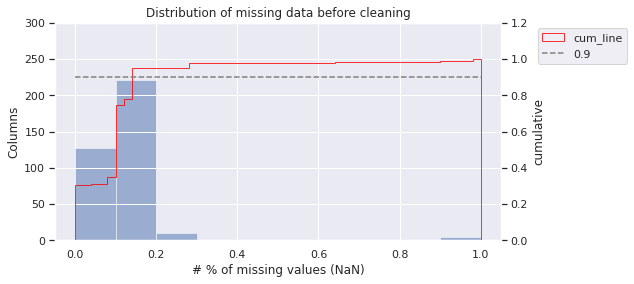

In [42]:
plot.Plot.print_null_dist(df_azdias, title='Distribution of missing data before cleaning')

In [43]:
print(df_azdias_cleaned['D19_LETZTER_KAUF_BRANCHE'].value_counts()[:5])

print(195338)

D19_UNBEKANNT         195338
D19_VERSICHERUNGEN     57734
D19_SONSTIGE           44722
D19_VOLLSORTIMENT      34812
D19_SCHUHE             32578
Name: D19_LETZTER_KAUF_BRANCHE, dtype: int64
195338


**Result** column `D19_LETZTER_KAUF_BRANCHE` has a huge number of values `D19_UNBEKANNT` which is aquivalent to unknown. Therefore this column will be dropped




In [44]:
# now let's mark all unknown columns as NaN
df_azdias_cleaned = dataCleaner._DataCleaner__mark_nans(df_azdias_cleaned)


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
replace unkown values by NaNs: 
 233 of 233columns
Fix col CAMEO_DEU_2015: replace XX by NaN

replace 0 by NaNs for : ['LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'GEBURTSJAHR']


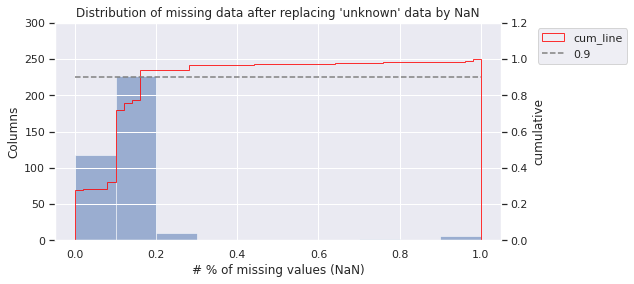

In [45]:
plot.Plot.print_null_dist(df_azdias_cleaned, title='Distribution of missing data after replacing \'unknown\' data by NaN')

Most columns have less than 30% missing values. Some columns have more than 50% missing data. Let's find them

In [46]:
num_of_records = df_azdias_cleaned.shape[0]
s_missing_data = df_azdias_cleaned.isnull().sum(axis=0)
s_missing_data_pct = df_azdias_cleaned.isnull().sum(axis=0) / num_of_records 

df_missing_data = pd.DataFrame({'abs':s_missing_data,'pct':s_missing_data_pct})
df_missing_data.sort_values(by='pct', ascending=False)[:25]


,abs,pct
ALTER_KIND4,890016,0.998648
TITEL_KZ,889061,0.997576
ALTER_KIND3,885051,0.993077
ALTER_KIND2,861722,0.966900
ALTER_KIND1,810163,0.909048
AGER_TYP,677503,0.760196
EXTSEL992,654153,0.733996
KK_KUNDENTYP,584612,0.655967
KBA05_BAUMAX,476524,0.534687
GEBURTSJAHR,392318,0.440203


**Results**: 
* There 21 variables with more than 25% missing values -> These are candidates to drop
* There are some variables that have all the same number of missing data (257113 - D19_...).
* the variables `ALTER_KIND1` - `ALTER_KIND4` have a huge number of missing values. This is because they are dependent on `ANZ_KINDER` (number of children) so that for all records with `ANZ_KINDER`=0 the values for `ALTER_KIND1`- `ALTER_KIND4` are missing. We will handle this in feature engineering part and build a new varaible for these features that aggregates the information


**Note**: The drop operation will be the last part as columns maybe needed during the feature engineering process


In [47]:
drop_level = 0.25
columns_to_drop = s_missing_data_pct.sort_values(ascending=False)
columns_to_drop = columns_to_drop[columns_to_drop>drop_level].index
columns_to_drop.sort_values().tolist()

['AGER_TYP',
 'ALTERSKATEGORIE_FEIN',
 'ALTER_HH',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_KONSUMTYP',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_LOTTO',
 'D19_SOZIALES',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'D19_VERSI_ONLINE_QUOTE_12',
 'EXTSEL992',
 'GEBURTSJAHR',
 'KBA05_BAUMAX',
 'KK_KUNDENTYP',
 'TITEL_KZ']

### Inverstigate  columns that throw an error
Info: just a copy from above [Data error during load](#Data-errors-during-load)

In [48]:
df_azdias_cleaned['CAMEO_DEUG_2015'].unique()

array([nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0, '4', '3', '7',
       '2', '8', '9', '6', '5', '1', 'X'], dtype=object)

Obviously the 'X' is causing the issue. I will replace this by np.NaN

In [49]:
df_azdias_cleaned['CAMEO_INTL_2015'].unique()

array([nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
       41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX'],
      dtype=object)

Obviously the 'XX' is causing the issue. I will replace this by np.NaN

### Handle Categorical Values

The datasets have a huge number of categorical variables. Most of the categorical variables are already encoded by int and floats, e.g. `AGER_TYP` is encoded by

|value  | meaning |
|-----  |---------|
|-1     |	unknown |
|0	    | no classification possible |
|1	    | passive elderly |
|2	    | cultural elderly |
|3	    | experience-driven elderly |

We keep this encoding as in many cases the categorical values are Ordinal and just some nominal, e.g.

variable `D19_TELKO_ANZ_12` the values are ordered from `very low activity` to `very high activity`

|value  | meaning |
|-----  |---------|
|0      | no transactions known            |
|1      | very low activity                |
|2      | low activity                     |
|3      | slightly increased activity      |
|4      | increased activity               |
|5      | high activity                    |
|6      | very high activity               |


However, some columns are of type = object. These are now investigated.

In [50]:
df_azdias_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891221 entries, 910215 to 825787
Columns: 365 entries, AGER_TYP to ALTERSKATEGORIE_GROB
dtypes: float64(298), int64(61), object(6)
memory usage: 2.5+ GB


In [51]:
df_azdias_cleaned.select_dtypes(include='object').head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
LNR,,,,,,
910215,NaN,NaN,NaN,NaN,NaN,NaN
910220,8A,8.0,51.0,NaN,1992-02-10 00:00:00,W
910225,4C,4.0,24.0,D19_UNBEKANNT,1992-02-12 00:00:00,W
910226,2A,2.0,12.0,D19_UNBEKANNT,1997-04-21 00:00:00,W
910241,6B,6.0,43.0,D19_SCHUHE,1992-02-12 00:00:00,W


#### Results Categorical:

|variable   | type      | action    |
|--         |--         | ---   	|
|CAMEO_DEU_2015| nominal | drop - this column seems to be based on not real measurable feature |
|D19_LETZTER_KAUF_BRANCHE | nominal | replace by one hot encoding |
| EINGEFUEGT_AM | date | drop - this is just the date when the record has been added |
| OST_WEST_KZ | nominal | replace by binary 0 and 1 |

`CAMEO_DEUG_2015` encoded categorical variable - contains invalid strings 'X'
`CAMEO_INTL_2015` encoded categorical variable - contains invalid strings 'XX'
`CAMEO_DEU_2015` will be dropped



### Variances
What are the columns with the largest variances?

In [52]:
variances = df_azdias_cleaned.std()
means = df_azdias_cleaned.mean() 
normed_variances_sorted = (variances/means).sort_values(ascending=False)
normed_variances_sorted[:20]

/home/ec2-user/anaconda3/envs/mxnet_latest_p37/lib/python3.7/site-packages/ipykernel/__main__.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  if __name__ == '__main__':
/home/ec2-user/anaconda3/envs/mxnet_latest_p37/lib/python3.7/site-packages/ipykernel/__main__.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  from ipykernel import kernelapp as app


D19_TELKO_ONLINE_QUOTE_12     28.445581
D19_VERSI_ONLINE_QUOTE_12     19.740712
ANZ_TITEL                     16.545504
SOHO_KZ                       10.849749
ANZ_HH_TITEL                   7.971861
D19_BANKEN_LOKAL               7.569399
D19_TELKO_ANZ_12               5.657827
D19_DIGIT_SERV                 5.269549
D19_BIO_OEKO                   4.855147
D19_NAHRUNGSERGAENZUNG         4.844734
D19_TIERARTIKEL                4.814624
D19_GARTEN                     4.738604
D19_BANKEN_ANZ_12              4.380982
D19_LEBENSMITTEL               4.118900
D19_TELKO_ANZ_24               3.983525
D19_WEIN_FEINKOST              3.955213
D19_ENERGIE                    3.855419
D19_VERSI_ANZ_12               3.828241
D19_BANKEN_ONLINE_QUOTE_12     3.619729
D19_BANKEN_REST                3.549392
dtype: float64

### Correlations
I will now analyse correlations between feature in order to identify feature that are highly correlated. This takes quite a while. Therefore I will use a sample of 30.0000 records instead of working on the compelte dataset

<AxesSubplot:>

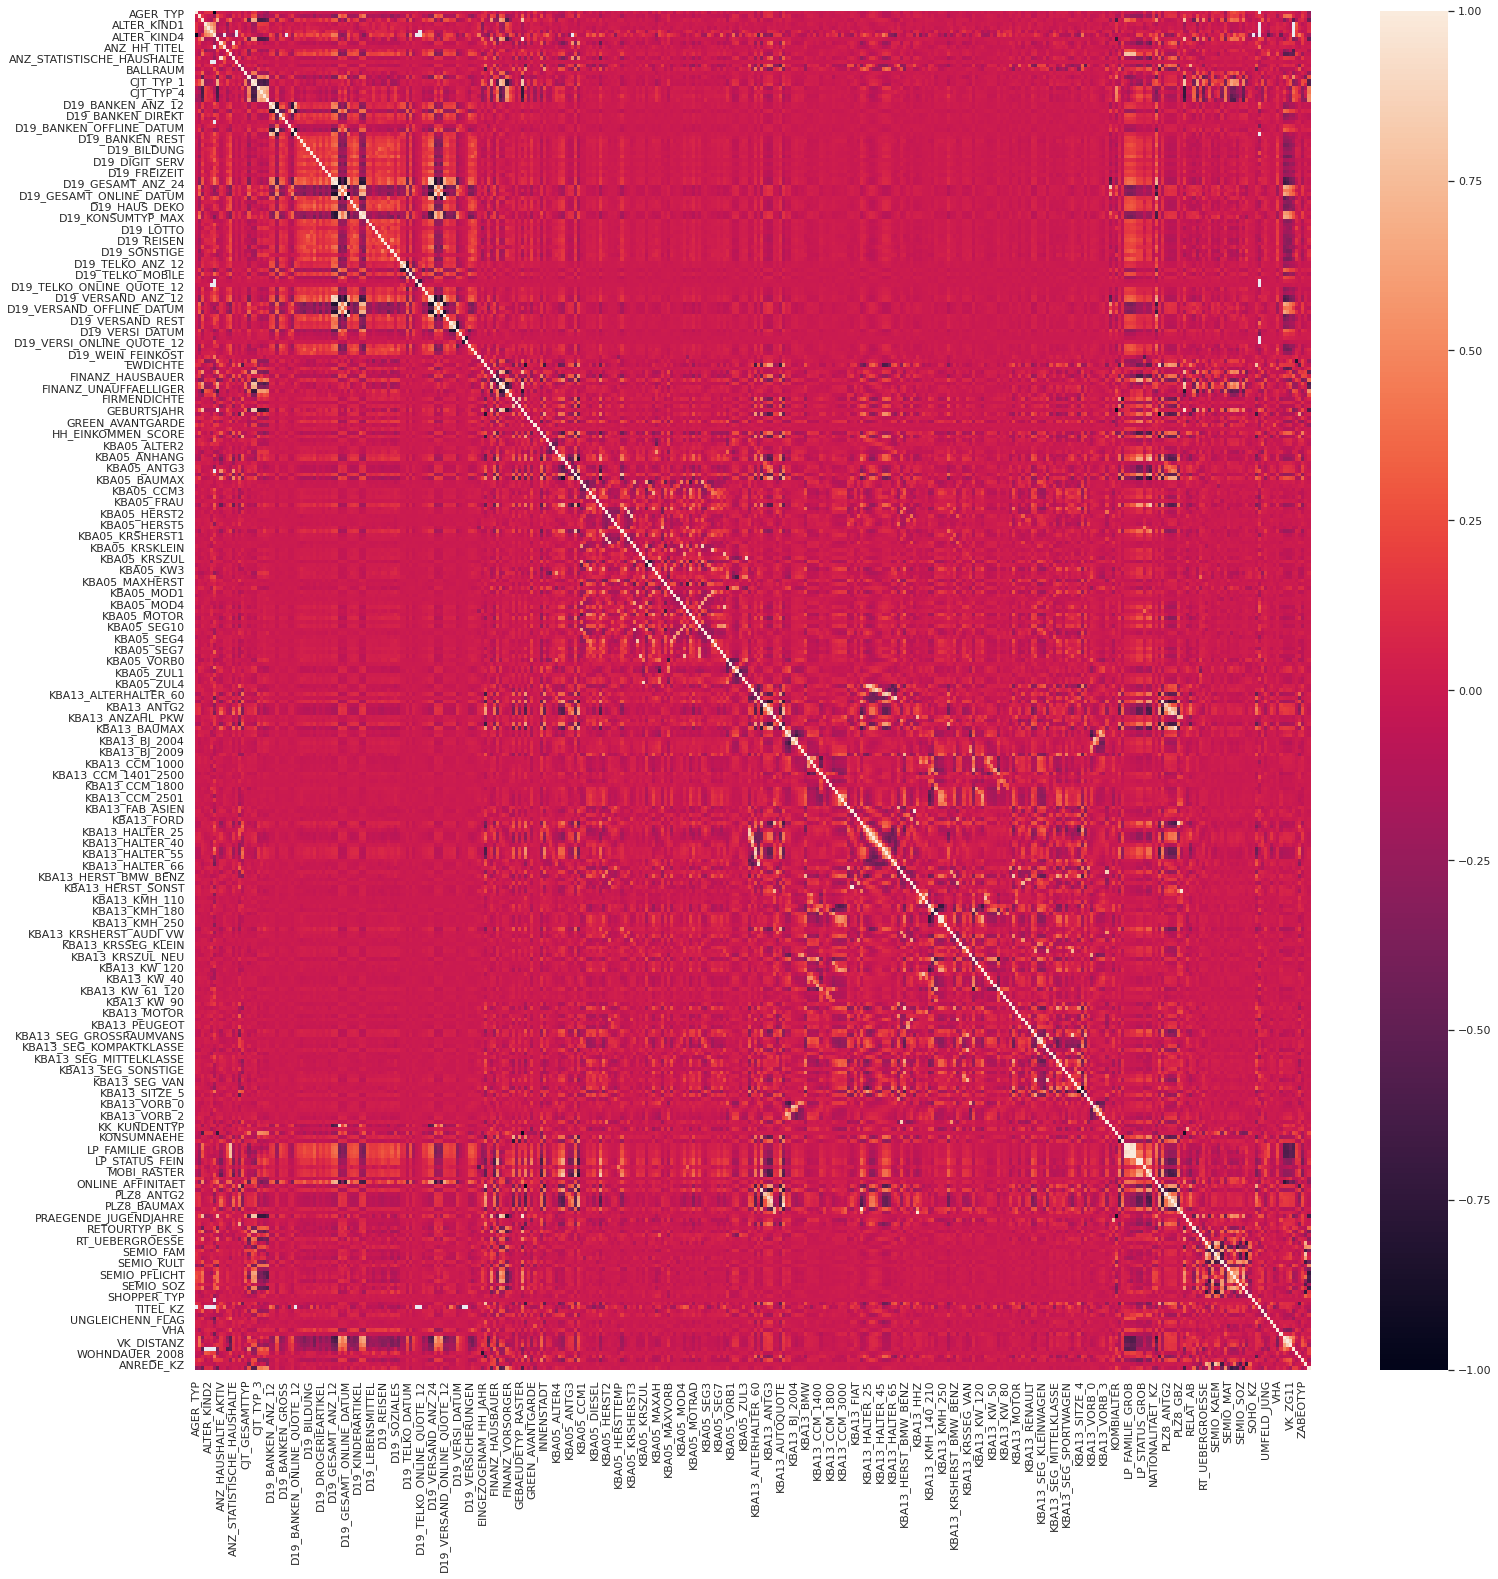

In [53]:
df_corr = df_azdias_cleaned.sample(30000).corr()
plt.figure(figsize=(25,25))
sns.heatmap(df_corr)

The heatmap shows a high correlation of KBA05* features, high correlation between some LP* features, between some D19* features,  between LP and some D19* features 

In [54]:
df_corr


,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,...,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
AGER_TYP,1.000000,0.051796,-0.015406,0.124970,0.125771,0.138137,-1.000000,0.034996,0.024085,0.022841,-0.008275,-0.027304,0.020868,0.017729,0.050329,-0.069749,0.053157,-0.035686,0.113226,0.153761,-0.089830,-0.054837,-0.136803,-0.204536,-0.012953,...,0.271134,0.198484,0.139444,0.179441,-0.022556,0.008751,0.005282,0.103020,NaN,0.011236,-0.033594,0.002200,0.051791,0.033464,-0.013067,0.016661,0.018727,0.029822,0.043062,0.008977,-0.028848,-0.075963,0.101329,0.059449,-0.265158
AKT_DAT_KL,0.051796,1.000000,0.151766,0.023354,-0.028045,-0.051352,-0.228842,0.302935,0.121132,0.030680,-0.082438,-0.139974,0.123195,-0.003867,0.095669,-0.056657,0.064407,0.006130,0.252963,0.281496,-0.267084,-0.140562,-0.248607,-0.191989,-0.109270,...,0.165650,0.190687,0.020240,0.165973,-0.105931,-0.046437,-0.007052,0.084053,0.142685,0.076165,-0.138496,0.056589,0.033676,0.046827,-0.179238,0.022740,0.375463,0.414546,0.390857,0.073866,-0.043910,-0.034984,0.177330,0.042980,-0.190646
ALTER_HH,-0.015406,0.151766,1.000000,0.006910,-0.064290,-0.157350,0.120128,0.717809,-0.062472,-0.053379,0.202727,0.383912,-0.080521,-0.029727,-0.068494,0.041793,0.343779,-0.502208,0.676972,0.652425,-0.626921,-0.634512,-0.597058,-0.506165,0.143047,...,0.356030,0.381245,0.070694,0.401323,-0.026590,-0.095145,0.000048,-0.045612,0.019538,0.327179,-0.102736,0.151411,-0.007162,0.002444,-0.014246,-0.054847,-0.338728,-0.132500,0.070695,-0.522632,-0.166593,0.057538,0.105673,-0.012099,-0.449562
ALTER_KIND1,0.124970,0.023354,0.006910,1.000000,0.770752,0.599040,0.473457,-0.177743,-0.040238,-0.012345,-0.282834,0.058071,-0.038626,0.003344,0.057355,-0.035307,-0.071558,0.029177,-0.232032,-0.226321,0.194554,0.175052,0.161353,0.140710,-0.041654,...,-0.067025,-0.067472,0.011726,-0.092107,0.053696,-0.007152,0.027684,-0.007927,NaN,-0.023826,0.012042,-0.094808,-0.015346,0.004505,0.076120,0.018149,0.071221,0.007017,-0.075919,NaN,0.307100,0.023214,-0.081228,-0.023194,0.089535
ALTER_KIND2,0.125771,-0.028045,-0.064290,0.770752,1.000000,0.742254,0.550033,-0.131266,-0.002552,0.018818,-0.175417,0.037698,-0.004608,-0.031449,0.057716,-0.020958,-0.101908,-0.005096,-0.169738,-0.154379,0.119556,0.081120,0.067966,0.103761,-0.020082,...,-0.069240,-0.056566,0.013435,-0.086595,0.015494,-0.012437,0.033080,-0.006037,NaN,0.000924,-0.030937,-0.058437,0.040022,0.038510,0.087349,0.054764,0.038254,-0.020780,-0.046832,NaN,0.266186,0.069031,-0.000919,-0.035823,0.084201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WOHNDAUER_2008,-0.028848,-0.043910,-0.166593,0.307100,0.266186,0.181325,0.193608,-0.267130,-0.055938,-0.009364,0.006560,0.197055,-0.043589,0.014487,-0.040561,0.032408,-0.084564,0.076228,-0.224974,-0.248362,0.187267,0.201357,0.199742,0.185996,-0.054280,...,-0.134300,-0.149141,-0.014274,-0.156634,0.034126,0.032937,0.004401,-0.041825,-0.039616,-0.061261,0.091774,-0.009322,-0.023663,-0.002961,0.137471,-0.028272,0.108067,-0.012124,-0.130865,-0.039518,1.000000,0.032168,-0.110745,-0.006252,0.179746
WOHNLAGE,-0.075963,-0.034984,0.057538,0.023214,0.069031,-0.000942,0.445861,0.008012,-0.085685,-0.042757,0.036625,0.061807,-0.086609,-0.018012,-0.298509,0.297760,-0.036229,-0.011544,-0.019860,-0.066748,0.069115,-0.016209,0.134761,0.030463,0.012337,...,0.000814,-0.004830,-0.036869,0.002362,-0

### find feature with greatest correlation

I will now search for feature with very high correlation (>0.925). For these features we keep one and drop the others

In [55]:
n = df_corr.shape[0]
df_ones = np.zeros((n,n))
np.fill_diagonal(df_ones, 1)
df_ones = pd.DataFrame(df_ones, index=df_corr.index, columns=df_corr.columns)

df_high_corr_cols = df_corr.columns[(abs(df_corr - df_ones) > 0.9).any()]
print(len(df_high_corr_cols))
df_corr.loc[df_high_corr_cols[:],df_high_corr_cols]

43


,AGER_TYP,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_STATISTISCHE_HAUSHALTE,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,GEBURTSJAHR,GEMEINDETYP,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG3,KBA13_ANTG4,KBA13_BAUMAX,KBA13_FAB_SONSTIGE,KBA13_GBZ,KBA13_HALTER_66,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_211,KBA13_KMH_250,KOMBIALTER,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,ORTSGR_KLS9,PLZ8_ANTG1,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ,PRAEGENDE_JUGENDJAHRE
AGER_TYP,1.000000,-1.000000,0.034996,0.024085,0.020868,-0.016842,-0.016547,0.008644,0.001160,-0.018610,-0.015701,0.015305,0.007505,-0.002944,0.041327,-0.100172,0.027402,-0.105630,0.111180,0.104245,0.090991,0.034871,-0.055610,0.034143,0.034871,0.036181,0.026307,0.022228,-0.035332,-0.040736,-0.026935,-0.046786,-0.056145,-0.099782,-0.093462,0.101640,-0.108083,0.114120,0.096656,0.088504,-0.058500,0.031822,0.042376
ALTER_KIND4,-1.000000,1.000000,-0.196213,-0.255502,-0.262923,0.448555,0.425669,-0.228959,0.274814,0.311872,0.333383,-0.113021,-0.128254,0.148638,-0.178720,0.072514,-0.460440,0.311205,-0.231146,-0.374279,-0.159878,-0.232832,0.136586,-0.416587,-0.232832,0.104736,-0.151695,-0.077896,-0.063327,-0.034835,-0.102170,-0.042197,-0.084113,0.253307,0.219514,-0.079013,0.291460,-0.202261,-0.308547,-0.084053,0.228255,0.066246,0.012008
ALTERSKATEGORIE_FEIN,0.034996,-0.196213,1.000000,0.007815,-0.005599,0.174183,0.200257,-0.216234,0.202156,0.152231,0.181166,-0.173340,-0.207596,0.197532,0.996851,-0.016759,-0.050667,-0.031525,0.023082,0.026513,0.040644,0.010823,0.000256,-0.048241,0.010823,0.025222,-0.022084,-0.018686,-0.719744,0.075105,0.093309,-0.021543,-0.027781,-0.127929,-0.159388,0.016844,-0.029028,0.028971,0.028291,0.045190,-0.002540,0.026404,0.765402
ANZ_HAUSHALTE_AKTIV,0.024085,-0.255502,0.007815,1.000000,0.971096,-0.107917,-0.120920,0.109622,-0.069064,-0.099366,-0.109384,0.115936,0.105658,-0.068074,0.001459,-0.257259,0.069680,-0.304065,0.258797,0.385995,0.338034,0.068406,-0.279709,0.062150,0.068406,0.101026,-0.023530,-0.025912,0.037193,-0.137719,-0.135375,-0.206101,-0.190119,-0.373253,-0.358074,0.290116,-0.305286,0.265523,0.376300,0.335446,-0.277878,0.094170,-0.016831
ANZ_STATISTISCHE_HAUSHALTE,0.020868,-0.262923,-0.005599,0.971096,1.000000,-0.114071,-0.128123,0.119345,-0.077746,-0.104952,-0.115830,0.124579,0.114841,-0.076536,-0.011881,-0.253640,0.070246,-0.303145,0.258190,0.385391,0.335991,0.070120,-0.279307,0.064134,0.070120,0.100867,-0.021019,-0.023799,0.040548,-0.141314,-0.141459,-0.209900,-0.192339,-0.374508,-0.358600,0.286116,-0.304281,0.264378,0.375981,0.333594,-0.277424,0.094777,-0.029104
D19_GESAMT_ANZ_12,-0.016842,0.448555,0.174183,-0.107917,-0.114071,1.000000,0.908192,-0.807281,0.717870,0.905939,0.857955,-0.797173,-0.780020,0.691096,0.113691,0.100984,-0.024667,0.146120,-0.145874,-0.133559,-0.128055,-0.039721,0.091340,-0.029043,-0.039721,-0.038908,0.007599,0.008407,-0.209551,0.315572,0.359498,0.366069,0.323023,0.195760,0.201018,-0.106546,0.146676,-0.146208,-0.134208,-0.125896,0.090610,-0.034491,0.148386
D19_GESAMT_ANZ_24,-0.016547,0.425669,0.200257,-0.120920,-0.128123,0.908192,1.000000,-0.845053,0.699980,0.829973,0.917685,-0.830658,-0.811638,0.675190,0.128432,0.108048,-0.026599,0.153319,-0.153841,-0.142818,-0.138247,-0.041571,0.099954,-0.030841,-0.041571,-0.038243,0.006689,0.008229,-0.247417,0.342423,0.393040,0.401115,0.352062,0.211543,0.219515,-0.112801,0.153932,-0.154427,-0.143147,-0.135079,0.098628,-0.034888,0.165368
D19_GESAMT_ONLINE_DATUM,0.008644,-0.228959,-0.216234,0.109622,0.119345,-0.807281,-0.845053,1.000000,-0.870170,-0.774399,-0.817190,0.912911,0.945251,-0.823582,-0.143915,-0.091144,0.020721,-0.139662,0.139513,0.127435,0.121321,0.031481,-0.090855,0.024404,0.031481,0.033568,-0.008890,-0.009913,0.266553,-0.310839,-0.368860,-0.374921,

In [56]:
def calc_high_correleted_columns (positive_corr:bool=True, corr_threshold:float=0.9):
    """
    calculates columns that are high correlated
    """
    high_corr_dict = {}
    candidate_to_drop = set()
    
    n = df_corr.shape[0]
    df_ones = np.zeros((n,n))
    np.fill_diagonal(df_ones, 1)
    df_ones = pd.DataFrame(df_ones, index=df_corr.index, columns=df_corr.columns)

    df_high_corr_cols = df_corr.columns[(abs(df_corr - df_ones) > corr_threshold).any()]    
    
    
    for col in df_corr.loc[df_high_corr_cols[:],df_high_corr_cols]:
        # if we search postive correlation then ascending must be upside down => therefore use the negative of positive_corr
        col_correaltions = df_corr[col].sort_values(ascending=(not positive_corr))
        tmp_list = []

        for corr_col in col_correaltions.index:
            if corr_col != col:
                if (abs(col_correaltions[corr_col]) >= corr_threshold) and not corr_col in high_corr_dict:
                    candidate_to_drop.add(corr_col)
                    tmp_list.append({corr_col : col_correaltions[corr_col]})
                else:
                    break

        if tmp_list:
            high_corr_dict[col] = tmp_list

    candidate_to_drop
    
    return {
        'candidate_to_drop' : candidate_to_drop,
        'high_corr_dict'    : high_corr_dict
    }

result = calc_high_correleted_columns()

Variation coefficient for some values

In [57]:
df_azdias_cleaned[['D19_VERSAND_ANZ_12','D19_VERSAND_ANZ_24']].std()/\
df_azdias_cleaned[['D19_VERSAND_ANZ_12','D19_VERSAND_ANZ_24']].mean()

D19_VERSAND_ANZ_12    1.902693
D19_VERSAND_ANZ_24    1.595062
dtype: float64

In [58]:
df_azdias_cleaned[['LP_FAMILIE_FEIN','LP_FAMILIE_GROB','LP_LEBENSPHASE_FEIN','LP_STATUS_GROB','LP_LEBENSPHASE_GROB']].std()/\
df_azdias_cleaned[['LP_FAMILIE_FEIN','LP_FAMILIE_GROB','LP_LEBENSPHASE_FEIN','LP_STATUS_GROB','LP_LEBENSPHASE_GROB']].mean()

LP_FAMILIE_FEIN        1.004830
LP_FAMILIE_GROB        0.803552
LP_LEBENSPHASE_FEIN    0.862832
LP_STATUS_GROB         0.606072
LP_LEBENSPHASE_GROB    0.756576
dtype: float64

Show for high correlated features the most correlated ones - where abs(correlation >0.9 

In [59]:
result['high_corr_dict']

{'ALTERSKATEGORIE_FEIN': [{'GEBURTSJAHR': 0.9968512632363309}],
 'ANZ_HAUSHALTE_AKTIV': [{'ANZ_STATISTISCHE_HAUSHALTE': 0.9710957742686299}],
 'D19_GESAMT_ANZ_12': [{'D19_GESAMT_ANZ_24': 0.9081915280769959},
  {'D19_VERSAND_ANZ_12': 0.9059389116140364}],
 'D19_GESAMT_ANZ_24': [{'D19_VERSAND_ANZ_24': 0.9176845800657714}],
 'D19_GESAMT_ONLINE_DATUM': [{'D19_VERSAND_ONLINE_DATUM': 0.9452513291353805},
  {'D19_VERSAND_DATUM': 0.9129105581497297}],
 'D19_GESAMT_ONLINE_QUOTE_12': [{'D19_VERSAND_ONLINE_QUOTE_12': 0.9186910185378406}],
 'D19_VERSAND_ANZ_12': [{'D19_VERSAND_ANZ_24': 0.9084625333625047}],
 'D19_VERSAND_DATUM': [{'D19_VERSAND_ONLINE_DATUM': 0.9561652049785794}],
 'KBA13_ALTERHALTER_61': [{'KBA13_HALTER_66': 0.9258415824543192}],
 'KBA13_ANTG1': [{'PLZ8_ANTG1': 0.9204417136085907}],
 'KBA13_ANTG3': [{'PLZ8_ANTG3': 0.9128298553741686}],
 'KBA13_ANTG4': [{'PLZ8_ANTG4': 0.9000567055690536}],
 'KBA13_BAUMAX': [{'PLZ8_BAUMAX': 0.9503794879181976}],
 'KBA13_FAB_SONSTIGE': [{'KBA13_HERST

In [60]:
result['candidate_to_drop']

{'ANZ_STATISTISCHE_HAUSHALTE',
 'D19_GESAMT_ANZ_24',
 'D19_VERSAND_ANZ_12',
 'D19_VERSAND_ANZ_24',
 'D19_VERSAND_DATUM',
 'D19_VERSAND_ONLINE_DATUM',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'GEBURTSJAHR',
 'KBA13_HALTER_66',
 'KBA13_HERST_SONST',
 'KBA13_KMH_250',
 'LP_FAMILIE_GROB',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'LP_STATUS_GROB',
 'PLZ8_ANTG1',
 'PLZ8_ANTG3',
 'PLZ8_ANTG4',
 'PLZ8_BAUMAX',
 'PLZ8_GBZ',
 'PLZ8_HHZ'}

<AxesSubplot:>

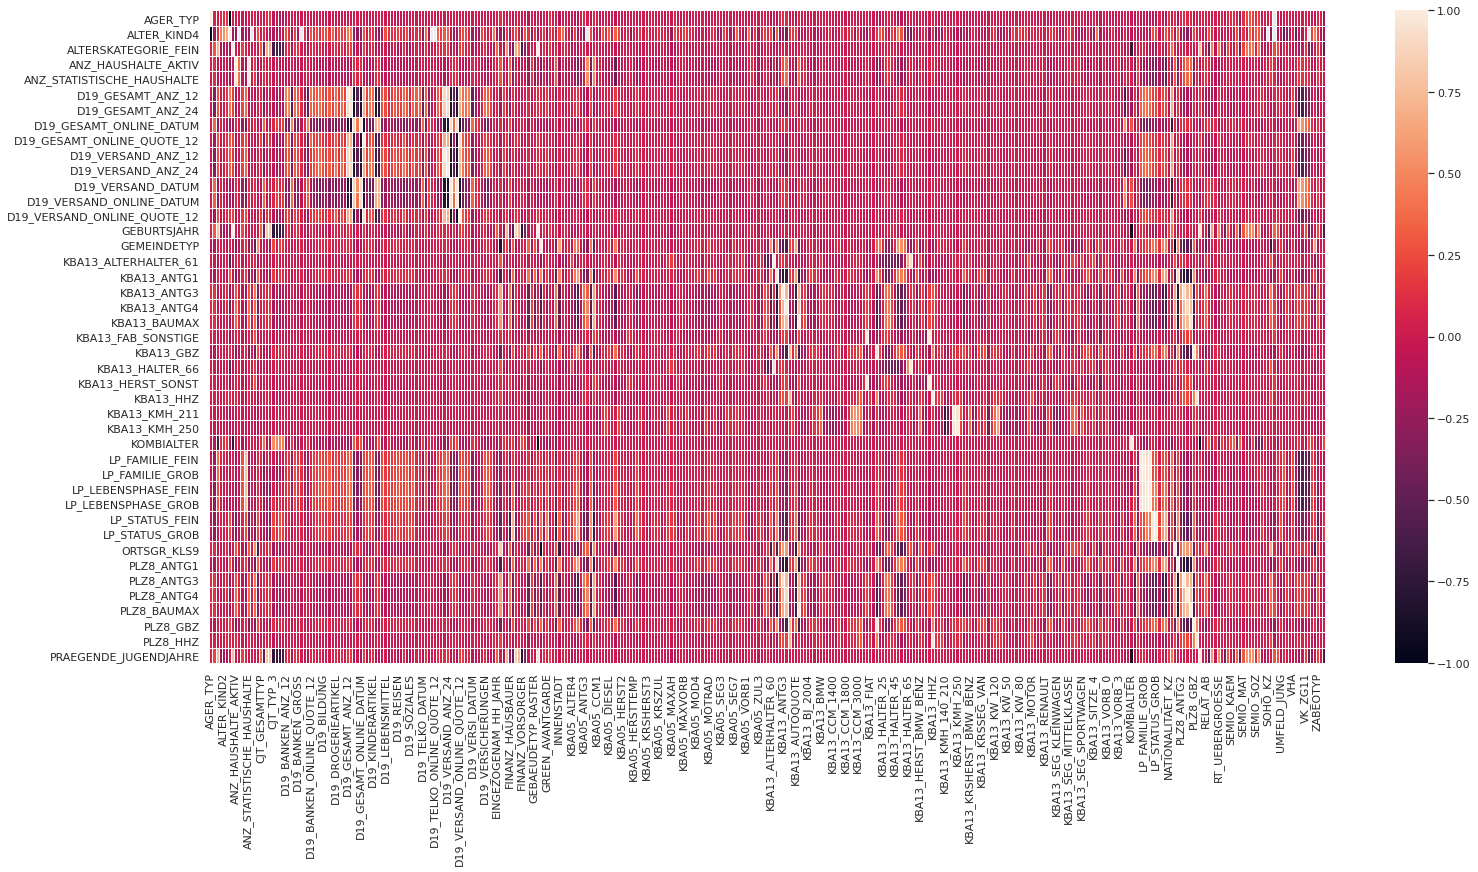

In [61]:
plt.figure(figsize=(25,12))
sns.heatmap(df_corr.loc[df_high_corr_cols,:], linewidths=0.8)


#### Analyse Variabls Lebensphase 

The following attributes seems to be very similar

* LP_LEBENSPHASE_GROB lifestage rough
* LP_LEBENSPHASE_FEIN lifestage fine
* LP_STATUS_FEIN
* LP_STATUS_GROB
* LP_FAMILIE_GROB
* LP_FAMILIE_FEIN

Therefore we make a short correlation check

In [62]:
cols = ['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','LP_STATUS_GROB', 'LP_STATUS_FEIN',  'LP_FAMILIE_GROB', 'LP_FAMILIE_FEIN', 'CAMEO_INTL_2015','CAMEO_DEUG_2015','W_KEIT_KIND_HH', 'CJT_TYP_1','CJT_TYP_2']
df_azdias_cleaned[cols].corr()

,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_GROB,LP_STATUS_FEIN,LP_FAMILIE_GROB,LP_FAMILIE_FEIN,W_KEIT_KIND_HH,CJT_TYP_1,CJT_TYP_2
LP_LEBENSPHASE_FEIN,1.000000,0.988180,0.463909,0.443415,0.941647,0.911927,-0.521635,-0.190931,-0.250607
LP_LEBENSPHASE_GROB,0.988180,1.000000,0.408800,0.417052,0.971096,0.959766,-0.526354,-0.071423,-0.128242
LP_STATUS_GROB,0.463909,0.408800,1.000000,0.982411,0.245960,0.237430,-0.156383,-0.259928,-0.336123
LP_STATUS_FEIN,0.443415,0.417052,0.982411,1.000000,0.234589,0.250205,-0.172990,-0.195305,-0.276832
LP_FAMILIE_GROB,0.941647,0.971096,0.245960,0.234589,1.000000,0.988211,-0.569255,-0.036257,-0.083982
LP_FAMILIE_FEIN,0.911927,0.959766,0.237430,0.250205,0.988211,1.000000,-0.549019,0.042804,-0.001035
W_KEIT_KIND_HH,-0.521635,-0.526354,-0.156383,-0.172990,-0.569255,-0.549019,1.000000,-0.330758,-0.272567
CJT_TYP_1,-0.190931,-0.071423,-0.259928,-0.195305,-0.036257,0.042804,-0.330758,1.000000,0.897413
CJT_TYP_2,-0.250607,-0.128242,-0.336123,-0.276832,-0.083982,-0.001035,-0.272567,0.897413,1.000000


<AxesSubplot:>

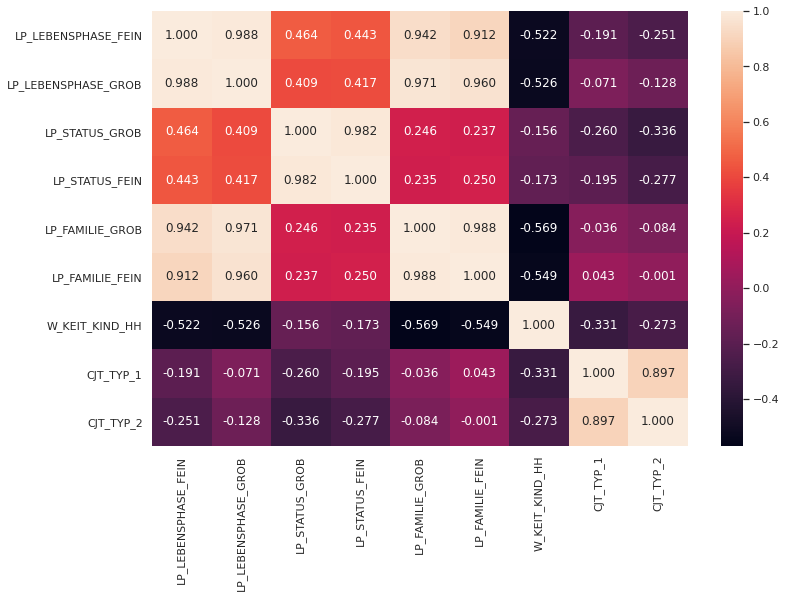

In [63]:
plt.figure(figsize=(12,8))
sns.heatmap(df_azdias_cleaned[cols].corr(), annot=True, fmt="3.3f")

### Result Correlation


* LP_STATUS_FEIN and LP_STATUS_GROB are almost the same. As LP_STATUS_FEIN contains the more detailed level of information we keep this and drop LP_STATUS_GROB
* These feature are high correlated. We keep just the first one (before the colon)
    * 'AGER_TYP': [{'ALTER_KIND4': 1.0}],
    * 'ALTERSKATEGORIE_FEIN': [{'GEBURTSJAHR': 0.9968743809543829}],
    * 'ANZ_HAUSHALTE_AKTIV': [{'ANZ_STATISTISCHE_HAUSHALTE': 0.9808116713431637}],
    * 'D19_GESAMT_ANZ_12': [{'D19_GESAMT_ANZ_24': 0.9095155307194449}, {'D19_VERSAND_ANZ_12': 0.9071122057751313}],
    * 'D19_GESAMT_ANZ_24': [{'D19_VERSAND_ANZ_24': 0.9212292939508165}],
    * 'D19_GESAMT_ONLINE_DATUM': [{'D19_VERSAND_ONLINE_DATUM': 0.9456178448898005},{'D19_VERSAND_DATUM': 0.9141231433613461}],
    * 'D19_GESAMT_ONLINE_QUOTE_12': [{'D19_VERSAND_ONLINE_QUOTE_12': 0.9180299872649309}],
    * 'D19_VERSAND_ANZ_12': [{'D19_VERSAND_ANZ_24': 0.9083758929241683}],
    * 'D19_VERSAND_DATUM': [{'D19_VERSAND_ONLINE_DATUM': 0.9579792563015092}],
    * 'KBA13_ALTERHALTER_61': [{'KBA13_HALTER_66': 0.9281420233171629}],
    * 'KBA13_ANTG1': [{'PLZ8_ANTG1': 0.9200697387600935}],
    * 'KBA13_ANTG3': [{'PLZ8_ANTG3': 0.9117595060863913}],
    * 'KBA13_BAUMAX': [{'PLZ8_BAUMAX': 0.9478190803990083}],
    * 'KBA13_FAB_SONSTIGE': [{'KBA13_HERST_SONST': 1.0}],
    * 'KBA13_GBZ': [{'PLZ8_GBZ': 0.9796453586957105}],
    * 'KBA13_HHZ': [{'PLZ8_HHZ': 0.9688164644363499}],
    * 'KBA13_KMH_211': [{'KBA13_KMH_250': 0.9574881863218665}],
    * 'LP_FAMILIE_FEIN': [{'LP_FAMILIE_GROB': 0.988280899204708},{'LP_LEBENSPHASE_GROB': 0.9597249546561574}, {'LP_LEBENSPHASE_FEIN': 0.9107770373340147}],
    * 'LP_LEBENSPHASE_FEIN': [{'LP_LEBENSPHASE_GROB': 0.9882002661772447}, {'LP_FAMILIE_GROB': 0.9407820493038201}],
    * 'LP_STATUS_FEIN': [{'LP_STATUS_GROB': 0.9823259377539101}],
    * 'PRAEGENDE_JUGENDJAHRE': [{'GEBURTSJAHR': 0.942482288813668}]}

### High Anti correlated features

In [64]:
result_neg = calc_high_correleted_columns(positive_corr=False, corr_threshold=0.9)

In [65]:
result_neg['candidate_to_drop']

{'ALTER_KIND4', 'KOMBIALTER', 'ORTSGR_KLS9'}

In [66]:
result_neg['high_corr_dict']

{'AGER_TYP': [{'ALTER_KIND4': -1.0}],
 'GEBURTSJAHR': [{'KOMBIALTER': -0.9329163460740976}],
 'GEMEINDETYP': [{'ORTSGR_KLS9': -0.9343662071915624}]}

## Run the cleaning process

In [67]:
df_azdias_cleaned = df_azdias.copy()
dfCleaner = cleaning.DataCleaner(drop_nan_threshold=0.3, df_metadata=df_metadata)

df_azdias_cleaned = dfCleaner.transform(df_azdias_cleaned, drop_duplicates=True, build_kind_features=True, drop_cols=True)
df_azdias_cleaned.shape

fixing load errors {'CAMEO_DEUG_2015': 'X', 'CAMEO_INTL_2015': 'XX'}
fixed column CAMEO_DEUG_2015 - records fixed: 373
fixed column CAMEO_INTL_2015 - records fixed: 373
fixing year columns: ['MIN_GEBAEUDEJAHR', 'EINGEZOGENAM_HH_JAHR', 'GEBURTSJAHR']

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
replace unkown values by NaNs: 
 233 of 233columns
Fix col CAMEO_DEU_2015: replace XX by NaN

replace 0 by NaNs for : ['LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'GEBURTSJAHR']

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
creating one hot encoding columns for: 
convert to binary: 
	column: OST_WEST_KZ - Mapping: {'W': 0, 'O': 1}

drop columns
Drop columns with too many Nulls:  ['AGER_TYP', 'ALTERSKATEGORIE_FEIN', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE'

(845439, 317)

### Check distribution of Missing values and Correclations again
check correlation again to see how it channged after the cleaning

<AxesSubplot:>

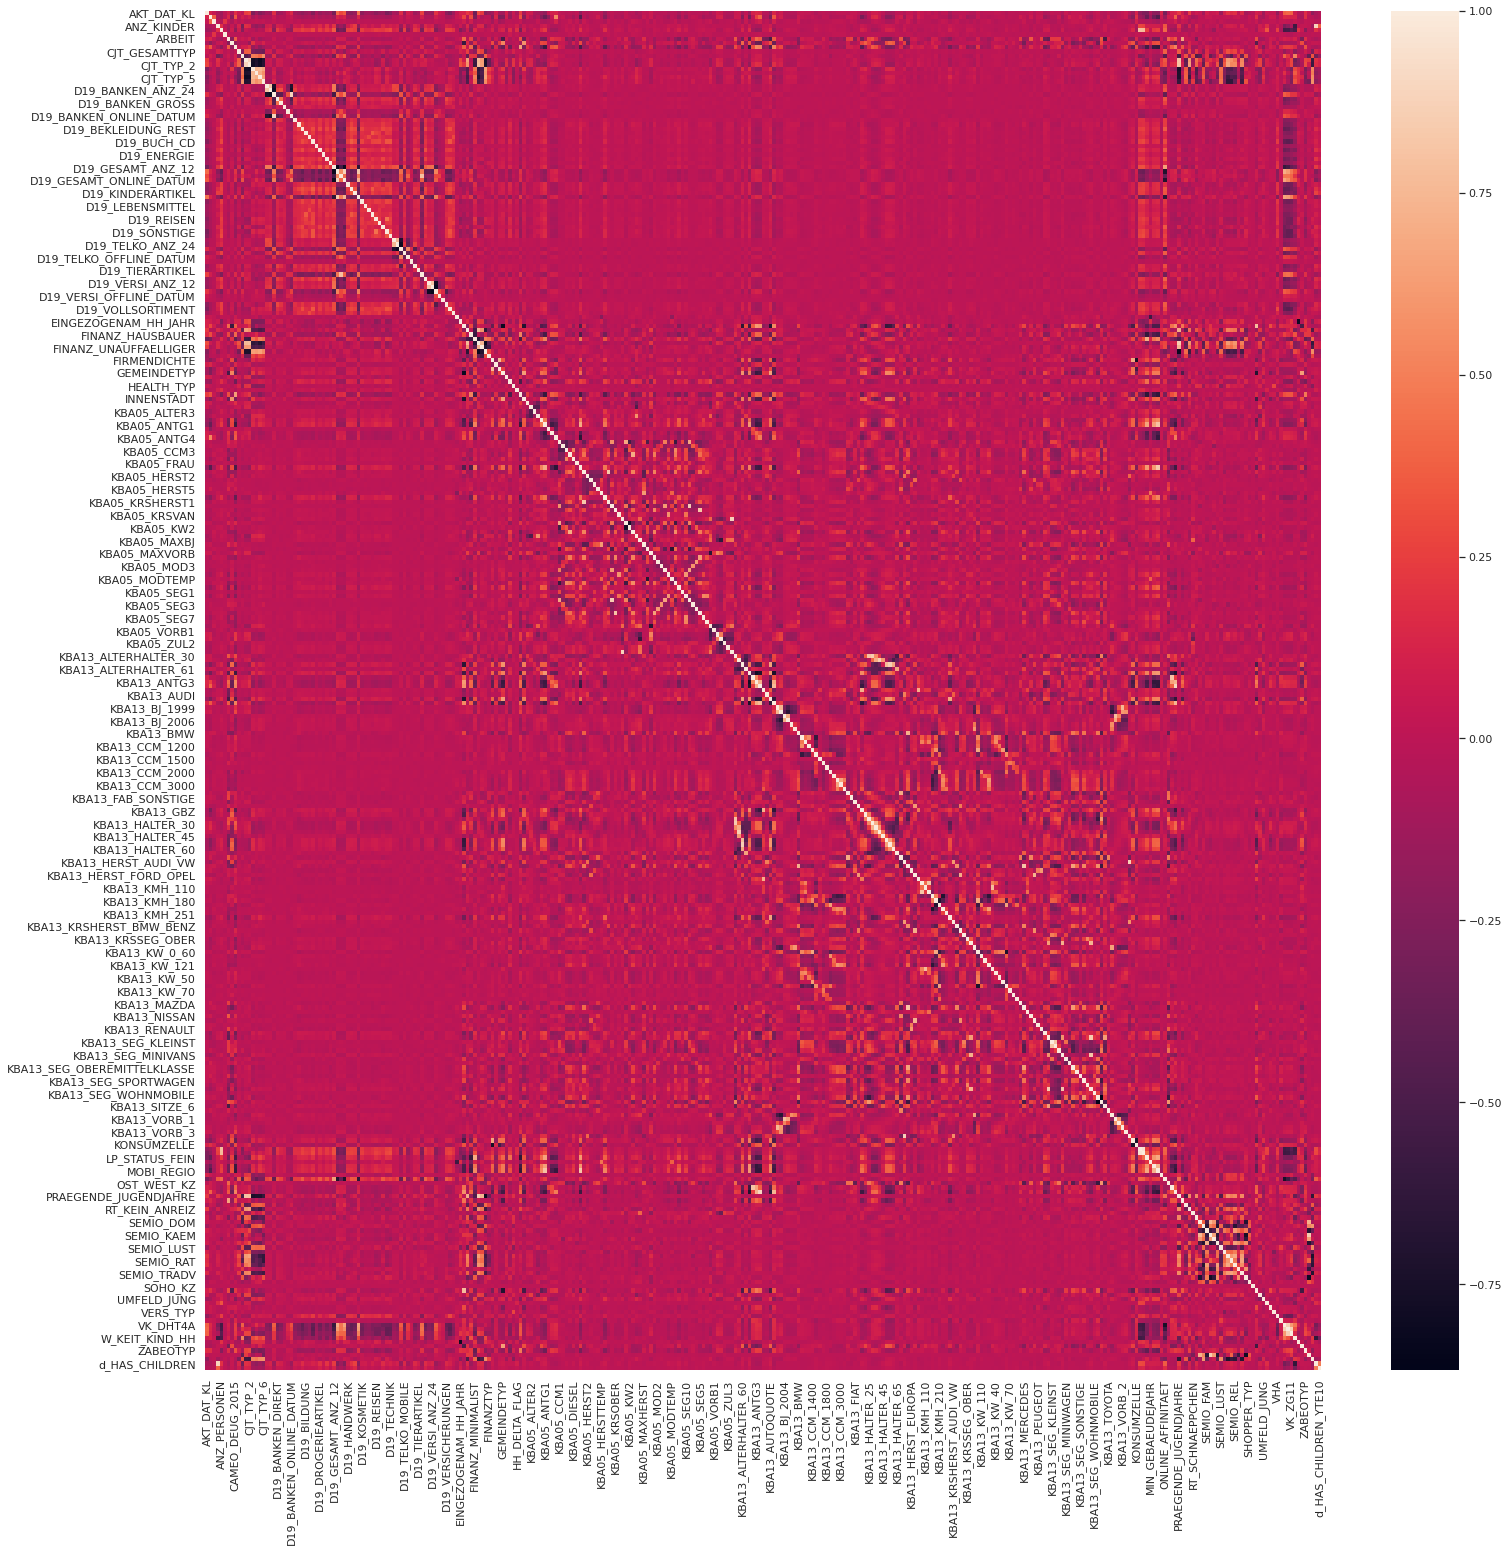

In [68]:
df_corr = df_azdias_cleaned.sample(30000).corr()
plt.figure(figsize=(25,25))
sns.heatmap(df_corr)

<AxesSubplot:>

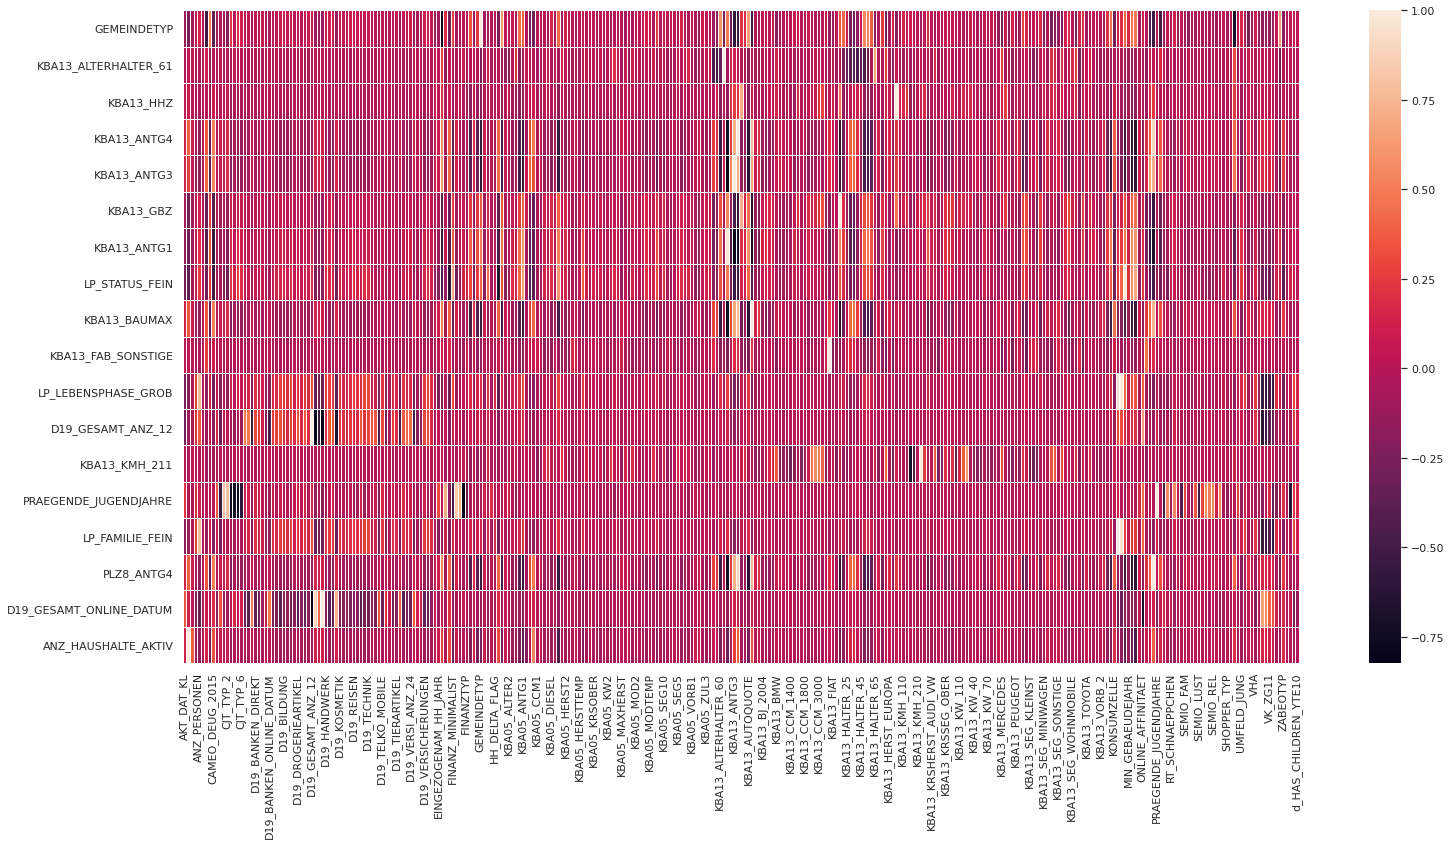

In [69]:
col_set = set(df_high_corr_cols).intersection(df_corr.columns)
plt.figure(figsize=(25,12))
sns.heatmap(df_corr.loc[col_set,:], linewidths=0.8)

In [70]:
calc_high_correleted_columns()

{'candidate_to_drop': {'LP_LEBENSPHASE_GROB', 'PLZ8_ANTG4'},
 'high_corr_dict': {'KBA13_ANTG4': [{'PLZ8_ANTG4': 0.9012498444177531}],
  'LP_FAMILIE_FEIN': [{'LP_LEBENSPHASE_GROB': 0.9598085945013474}]}}

In [71]:
calc_high_correleted_columns(False)

{'candidate_to_drop': set(), 'high_corr_dict': {}}

**Correlation Analysis Results**
As you can see the number of highly positive and negative correlation is much less after the cleaning

### Compare Null distribution before and after cleaning

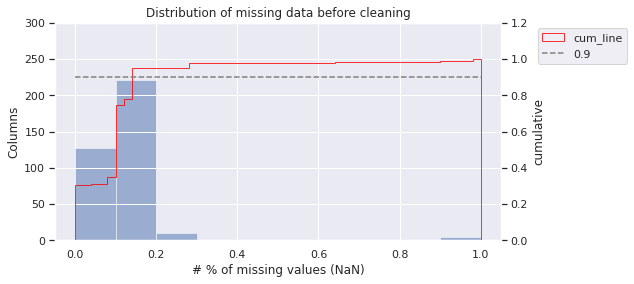

In [75]:
# Assess missing data in columns
plot.Plot.print_null_dist(df_azdias, 'dist_of_missingdata_after_transformation.jpg', title='Distribution of missing data before cleaning')

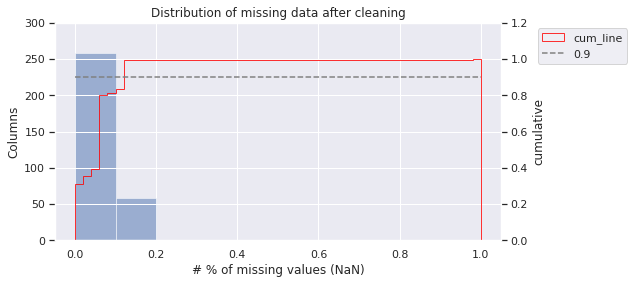

In [73]:
plot.Plot.print_null_dist(df_azdias_cleaned, 'dist_of_missingdata_after_transformation.jpg', title='Distribution of missing data after cleaning')

**Check where the differences come from**
build 2 dataframes that contain the number of missing values per column for the dataset before and after cleaning. Then merge them in order to compare the before and after state.

In [76]:
# after 
num_of_records = df_azdias_cleaned.shape[0]
s_missing_data = df_azdias_cleaned.isnull().sum(axis=0)
s_missing_data_pct = df_azdias_cleaned.isnull().sum(axis=0) / num_of_records 

df_missing_data = pd.DataFrame({'abs':s_missing_data,'pct':s_missing_data_pct})
df_missing_data.sort_values(by='pct', ascending=False)[:20]

# same for before
num_of_records_orig = df_azdias.shape[0]
s_missing_data_orig = df_azdias.isnull().sum(axis=0)
s_missing_data_pct_orig = df_azdias.isnull().sum(axis=0) / num_of_records_orig

df_missing_data_orig = pd.DataFrame({'abs':s_missing_data_orig,'pct':s_missing_data_pct_orig})
df_missing_data_merged = pd.merge(left=df_missing_data_orig, right=df_missing_data, how='outer', left_index=True, right_index=True, suffixes=['_orig','_cleaned'])
df_missing_data_merged['diff_abs'] = df_missing_data_merged['abs_orig'] - df_missing_data_merged['abs_cleaned']

**Results**: There is a significant increase of columns with less missing data

The main reason are:

* some "unknown" values were replaced values by np.NaN
* duplicate rows have been removed. There are for many columns the same number of removed missing values ~45730. This is the cause the decrease of number of columns for bin 2 (10-20%) and increas of bin 1 (0% - 10%)

# Save cleaned Datasets
Note: using feather requires to reset the index

In [79]:
df_azdias_cleaned.reset_index().to_feather('df_azdias_cleaned')

# Loading DF - Start for Segmentation
you can start here if you want to skip steps before

In [9]:
df_azdias_cleaned = pd.read_feather('df_azdias_cleaned')

# set the index as feather did store the index as column
df_azdias_cleaned.set_index('LNR', inplace=True)
df_azdias_cleaned.head()

,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,...,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,d_HAS_CHILDREN,d_HAS_CHILDREN_YTE10
LNR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,...,7.0,2.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0,0,0
910220,9.0,11.0,0.0,0.0,2.0,0.0,3.0,6.0,8.0,5.0,1.0,5.0,5.0,2.0,3.0,1.0,1.0,0,0,10,0,0,0,10,10,...,4.0,5.0,6.0,1.0,3.0,1.0,2.0,3.0,3.0,1.0,0.0,2.0,0.0,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0,0,0
910225,9.0,10.0,0.0,0.0,1.0,0.0,3.0,2.0,4.0,3.0,2.0,4.0,4.0,1.0,3.0,2.0,2.0,0,0,10,0,0,0,10,10,...,3.0,4.0,3.0,4.0,2.0,0.0,3.0,2.0,5.0,0.0,1.0,1.0,0.0,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0,0,0
910226,1.0,1.0,0.0,0.0,0.0,0.0,2.0,4.0,2.0,2.0,3.0,2.0,2.0,4.0,4.0,5.0,3.0,0,0,10,0,0,0,10,10,...,2.0,5.0,4.0,4.0,1.0,0.0,1.0,4.0,5.0,0.0,0.0,1.0,1.0,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0,0,0
910241,1.0,3.0,0.0,0.0,4.0,0.0,4.0,2.0,6.0,5.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,3,5,5,1,2,0,10,5,...,4.0,6.0,2.0,7.0,2.0,0.0,3.0,4.0,3.0,0.0,1.0,2.0,0.0,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0,0,0


# Part 1: Customer Segmentation Report
----

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Cluster algorithms
For clustering there is number of popular algorithms. For the algorthim selection I focused on the ones that scikit-learn provides and on the article [clustering algorithms with python](https://machinelearningmastery.com/clustering-algorithms-with-python/) or [How to Combine PCA and K-means CLustering.](https://365datascience.com/tutorials/python-tutorials/pca-k-means/)

According to the references the most popular algorithms are

* Affinity Propagation
* Agglomerative Clustering
* BIRCH
* DBSCAN
* **K-Means**
* **Mini-Batch K-Means**
* Mean Shift
* OPTICS
* Spectral Clustering
* Mixture of Gaussians

the bold one are the one(s) I used

## Feature Reduction and Selection
The dimension of the dataset is quite high (442 features) so that it is worth to consider a reduction of the dimensionality which will increase the performance and in many cases the accuracy of algorithm. In particular the popular K-means which I will use will profit from it.

See e.g. [PCA with k-means](https://365datascience.com/tutorials/python-tutorials/pca-k-means/)

## Approach
1. PCA - Principal Component Analysis
This algorithms is also provided by scikit-learn. It will transform the given space of features to new space with basis vectors that are linear combinations of the given features so that the new vectors point in direction of the maximum variance. For more information how to execute and interpret the values see [In Depth: Principal Component Analysis](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html)

    1. Impute missing data
    1. Standardize data
    1. Execute PCA
1. K-means

For the complete process I will use a sklearn pipeline to chain the steps

## Visualize Data

In [12]:
pd.set_option('display.max_seq_items', 400)

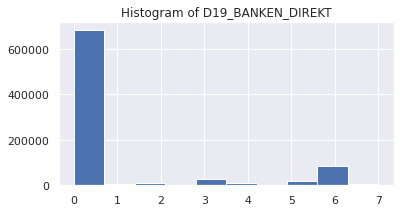

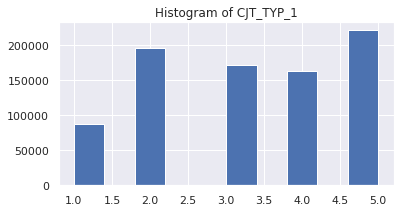

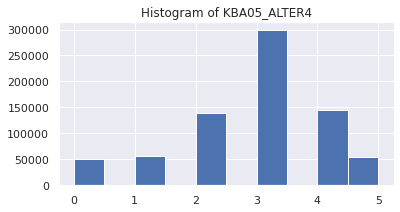

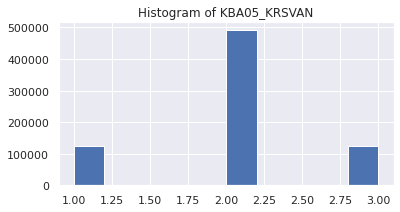

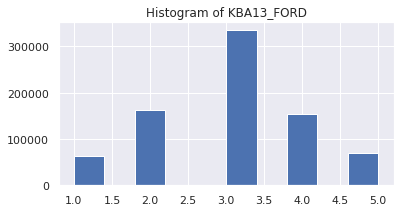

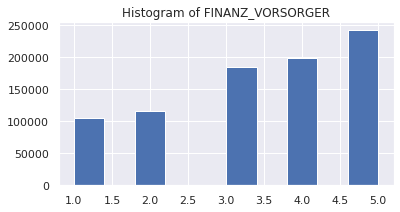

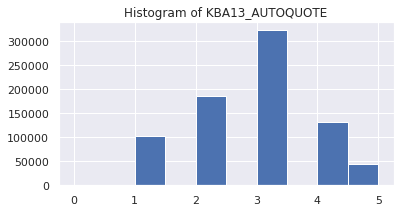

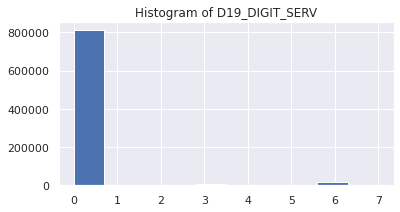

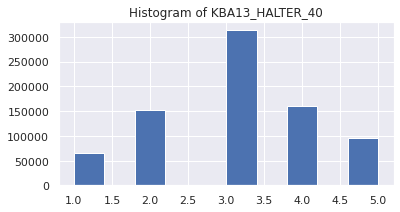

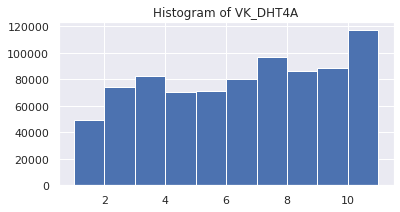

In [25]:
# transportation (to work)
col_list = pd.Series(df_azdias_cleaned.columns.values).sample(10, random_state=123).to_numpy()
n_bins = 10 # can decrease to get a wider bin (or vice versa)

for column_name in col_list:
    ax=plt.subplots(figsize=(6,3))
    # get data by column_name and display a histogram
    ax = plt.hist(df_azdias_cleaned[column_name], bins=n_bins)    
    title="Histogram of " + column_name
    plt.title(title, fontsize=12)
    plt.show()

In [46]:
df_azdias_cleaned=None

---

## Step 1 - Prepare the Data
First prepare the data for the PCA and KMEans process as described in the overview. This follows the approach referenced in the overview above.

* Load libs
* load data
* impute missing values
* standardize

<div style="background-color:lightblue;padding:20px;">
    Requires Kernel <strong>conda_mxnet_latest_py37</strong> or one with similar lib versions like pandas 1.3.4 etc.
</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import progressbar
from IPython.display import display, HTML
import joblib

# magic word for producing visualizations in notebook
%matplotlib inline
sns.set_theme()

In [3]:
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from utils.plot import Plot
import preprocessing.cleaning as cleaning



In [4]:
import os

# this is NOT needed if you start from the beginning
if os.path.exists('data') and os.path.isdir('data'):
    prefix = './data'
else:
    raise Exception('No data')

#df_azdias = pd.read_csv(f'{prefix}/Udacity_AZDIAS_052018.csv', sep=';', index_col='LNR')
df_customers  = pd.read_csv(f'{prefix}/Udacity_CUSTOMERS_052018.csv', sep=';', index_col='LNR')
df_population = pd.read_csv(f'{prefix}/Udacity_AZDIAS_052018.csv', sep=';', index_col='LNR')
df_metadata = pd.read_excel(f'{prefix}/DIAS Attributes - Values 2017.xlsx', usecols='B:E', dtype='str', header=1).fillna(method='ffill')

/home/ec2-user/anaconda3/envs/mxnet_latest_p37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
# some columns of the metadata ends on _RZ whereas the datasets have the same columns whcih do not end on _RZ
# therefore we replace this
df_metadata['Attribute'] = df_metadata['Attribute'].str.replace('_RZ','')

In [6]:
dfCleaner = cleaning.DataCleaner(drop_nan_threshold=0.3, df_metadata=df_metadata)


In [7]:
df_customer_cleaned   = dfCleaner.transform(df_customers, drop_cols=True)
df_customers = None

Dropping customer dataset cols: ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
dropping columns: ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
fixing load errors {'CAMEO_DEUG_2015': 'X', 'CAMEO_INTL_2015': 'XX'}
fixed column CAMEO_DEUG_2015 - records fixed: 126
fixed column CAMEO_INTL_2015 - records fixed: 126
fixing year columns: ['MIN_GEBAEUDEJAHR', 'EINGEZOGENAM_HH_JAHR', 'GEBURTSJAHR']

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
replace unkown values by NaNs: 
 233 of 233columns
Fix col CAMEO_DEU_2015: replace XX by NaN

replace 0 by NaNs for : ['LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'GEBURTSJAHR']

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
creating one hot encoding columns for: 
convert to binary: 
	column: OST_WEST_KZ - Mapping: {'W': 0, 'O': 1}

In [8]:
df_population_cleaned = dfCleaner.transform(df_population, drop_cols=True)
df_population = None

df_population_cleaned.head()

fixing load errors {'CAMEO_DEUG_2015': 'X', 'CAMEO_INTL_2015': 'XX'}
fixed column CAMEO_DEUG_2015 - records fixed: 373
fixed column CAMEO_INTL_2015 - records fixed: 373
fixing year columns: ['MIN_GEBAEUDEJAHR', 'EINGEZOGENAM_HH_JAHR', 'GEBURTSJAHR']

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
replace unkown values by NaNs: 
 233 of 233columns
Fix col CAMEO_DEU_2015: replace XX by NaN

replace 0 by NaNs for : ['LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'GEBURTSJAHR']

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
creating one hot encoding columns for: 
convert to binary: 
	column: OST_WEST_KZ - Mapping: {'W': 0, 'O': 1}

drop columns
Drop columns with too many Nulls:  ['AGER_TYP', 'ALTERSKATEGORIE_FEIN', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE'

,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,d_HAS_CHILDREN,d_HAS_CHILDREN_YTE10
LNR,,,,,,,,,,,,,,,,,,,,,
910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0,0,0
910220,9.0,11.0,0.0,0.0,2.0,0.0,3.0,6.0,8.0,5.0,...,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0,0,0
910225,9.0,10.0,0.0,0.0,1.0,0.0,3.0,2.0,4.0,3.0,...,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0,0,0
910226,1.0,1.0,0.0,0.0,0.0,0.0,2.0,4.0,2.0,2.0,...,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0,0,0
910241,1.0,3.0,0.0,0.0,4.0,0.0,4.0,2.0,6.0,5.0,...,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0,0,0


## Save Cleaned Data as CSV

In [8]:
df_customer_cleaned.to_csv('./data/customers_cleaned.csv')
df_population_cleaned.to_csv('./data/population_cleaned.csv')



# SageMaker Preparation
The data SageMaker preparation follows the [Udacity Segmentation ML case study](https://github.com/udacity/ML_SageMaker_Studies/blob/master/Population_Segmentation/Pop_Segmentation_Solution.ipynb) and the AWS Example [Amazon Sagemaker Examples](https://github.com/aws/amazon-sagemaker-examples/blob/master/sagemaker_processing/scikit_learn_data_processing_and_model_evaluation/scikit_learn_data_processing_and_model_evaluation.ipynb)

1. prepare SageMaker
1. Upload data to SageMaker
1. create preprocessing script

    Impute and Scale data
1. fit data for preprocessing
1. batch training data
1. fit PCA model with preprocessed data
1. create inference pipeline for on-demand inference (new since Dec-2021)

## Step 1 - Prepare Sagemaker

In [95]:
# sagemaker libraries
import boto3
import sagemaker
from sagemaker import get_execution_role

session = sagemaker.Session() # store the current SageMaker session

# get IAM role
role = get_execution_role()
print(role)

arn:aws:iam::675510605794:role/c20300a265023l1068766t1w6-SageMakerNotebookInstanc-2E3E8LCEF390


In [96]:
# get default bucket
bucket_name = session.default_bucket()
print(bucket_name)
print()

sagemaker-us-east-1-675510605794



In [97]:
# define location to store model artifacts
prefix = 'ml-segmentation-arvato'

output_path='s3://{}/{}/'.format(bucket_name, prefix)

print('Training artifacts will be uploaded to: {}'.format(output_path))

Training artifacts will be uploaded to: s3://sagemaker-us-east-1-675510605794/ml-segmentation-arvato/


## Step 2 - Upload input data for Sagemaker

In [98]:
DATA_DIRECTORY = 'data'

train_input_customers = session.upload_data(
    path='{}/{}'.format(DATA_DIRECTORY, 'customers_cleaned.csv'), 
    bucket=bucket_name,
    key_prefix='{}/{}'.format(prefix, 'train'))

train_input_population = session.upload_data(
    path='{}/{}'.format(DATA_DIRECTORY, 'population_cleaned.csv'), 
    bucket=bucket_name,
    key_prefix='{}/{}'.format(prefix, 'train'))

## Step 3 - Create Preprocessing Script

To run Scikit-learn on Sagemaker SKLearn Estimator with a script as an entry point. 

The training environment provides various environment variables, such as:

* SM_MODEL_DIR: A string representing the path to the directory to write model artifacts to. These artifacts are uploaded to S3 for model hosting.
* SM_OUTPUT_DIR: A string representing the filesystem path to write output artifacts to. Output artifacts may include checkpoints, graphs, and other files to save, not including model artifacts. These artifacts are compressed and uploaded to S3 to the same S3 prefix as the model artifacts.

Supposing two input channels, 'train' and 'test', were used in the call to the Chainer estimator's fit() method, the following will be set, following the format SMCHANNEL\[channel_name\]:

* SM_CHANNEL_TRAIN: A string representing the path to the directory containing data in the 'train' channel
* SM_CHANNEL_TEST: Same as above, but for the 'test' channel.

The training script will load data from the input channels, configures training with hyperparameters, trains a model, and saves a model to model_dir so that it can be hosted later. Hyperparameters are passed to your script as arguments and can be retrieved with an argparse.ArgumentParser instance. 

In [99]:
%%writefile preprocessing_script.py

import argparse
import os
import warnings
import boto3

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import make_column_transformer

from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings(action="ignore", category=DataConversionWarning)

"""
columns = [
    "age",
    "education",
    "major industry code",
    "class of worker",
    "num persons worked for employer",
    "capital gains",
    "capital losses",
    "dividends from stocks",
    "income",
]
class_labels = [" - 50000.", " 50000+."]
"""

"""
def print_shape(df):
    negative_examples, positive_examples = np.bincount(df["income"])
    print(
        "Data shape: {}, {} positive examples, {} negative examples".format(
            df.shape, positive_examples, negative_examples
        )
    )
"""

def scale_and_impute(X_train):
    """
    Description
    -----------
        this method scales data to [0,1] and imputes missing values


     Return
    ------
        pd.DataFrame : result scale and impute method
    """
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    scaler  = StandardScaler()
    
    col_names = X_train.columns
    index = X_train.index

    # scale
    print('Scaling dataset')
    df = scaler.fit_transform(X_train)
    # impute
    print('Imputing missing values')
    df = pd.DataFrame(imputer.fit_transform(df))

    df.set_index(index, inplace=True)
    df.columns = col_names
    
    print('Scale and Impute transformation completed.')

    return df

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    
    #parser.add_argument("--n_pca_components", type=int, default=10)
    args, _ = parser.parse_known_args()

    print("Received arguments {}".format(args))

    population_input_data_path = os.path.join("/opt/ml/processing/input", "population_cleaned.csv")
    #customers_input_data_path = os.path.join("/opt/ml/processing/input2", "customers_cleaned.csv")

    print("Reading input data from {}".format(population_input_data_path))    
    df_population = pd.read_csv(population_input_data_path)    
    print("Running preprocessing transformations for population data")
    df_population = scale_and_impute(df_population)
    
    #print("Reading input data from {}".format(customers_input_data_path))
    #df_customers = pd.read_csv(customers_input_data_path)    
    #print("Running preprocessing transformations for customers data")
    #df_customers = scale_and_impute(df_customers)


    print("Population data shape after preprocessing: {}".format(df_population.shape))
    #print("Customers data shape after preprocessing: {}".format(df_customers.shape))

    train_population_output_path = os.path.join("/opt/ml/processing/train", "train_population.csv")
    #train_customers_output_path = os.path.join("/opt/ml/processing/train", "train_customers.csv")

    print("Saving training features to {}".format(train_population_output_path))
    pd.DataFrame(df_population).to_csv(train_population_output_path, header=False, index=False)
    
    #print("Saving test features to {}".format(train_customers_output_path))
    #pd.DataFrame(df_customers).to_csv(train_customers_output_path, header=False, index=False)



Overwriting preprocessing_script.py


Now we can run this script as a processing job by using the `SKLearnProcessor.run()` method which takes the ProcessingInput where the source is location of the dataset in Amazon S3, and the `destination` is where the script reads this data from, in this case `/opt/ml/processing/input`. These local paths inside the processing container must begin with `/opt/ml/processing/`.

The second parameter of the `run()` method a `ProcessingOutput`, where the `source` is the path the script writes output data to. For outputs, the destination defaults to the SAgeMaker S3 bucket, following the format `s3://sagemaker-<region>-<account_id>/<processing_job_name>/output/<output_name>/`. 

The `arguments` parameter in the `run()` method are command-line arguments in our preprocessing.py script.

In [100]:
train_input_population = 's3://sagemaker-us-east-1-675510605794/ml-segmentation-arvato/train/population_cleaned.csv'
#= 's3://sagemaker-us-east-1-675510605794/ml-segmentation-arvato/train/customers_cleaned.csv'

In [16]:
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.sklearn.processing import SKLearnProcessor

sklearn_processor = SKLearnProcessor(
    framework_version="0.20.0", role=role, instance_type="ml.m5.xlarge", instance_count=1
)

sklearn_processor.run(
    code="preprocessing_script.py",
    inputs=[ProcessingInput(source=train_input_population, destination="/opt/ml/processing/input")],
    outputs=[
        ProcessingOutput(output_name="train_data", source="/opt/ml/processing/train")
        #ProcessingOutput(output_name="test_data", source="/opt/ml/processing/test"),
    ]
)

preprocessing_job_description = sklearn_processor.jobs[-1].describe()

output_config = preprocessing_job_description["ProcessingOutputConfig"]
for output in output_config["Outputs"]:
    if output["OutputName"] == "train_data":
        preprocessed_training_data = output["S3Output"]["S3Uri"]
    if output["OutputName"] == "test_data":
        preprocessed_test_data = output["S3Output"]["S3Uri"]


Job Name:  sagemaker-scikit-learn-2021-12-27-09-21-02-837
Inputs:  [{'InputName': 'input-1', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-675510605794/ml-segmentation-arvato/train/population_cleaned.csv', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-675510605794/sagemaker-scikit-learn-2021-12-27-09-21-02-837/input/code/preprocessing_script.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'train_data', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-675510605794/sagemaker-scikit-learn-2021-12-27-09-21-02-837/output/train_data', 'LocalPath': '/opt/ml/processing/train', 'S3UploadMode': '

Now inspect the output of the pre-processing job, which consists of the processed features.

In [17]:
preprocessing_job_description = sklearn_processor.jobs[-1].describe()
preprocessing_job_description

{'ProcessingInputs': [{'InputName': 'input-1',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-675510605794/ml-segmentation-arvato/train/population_cleaned.csv',
    'LocalPath': '/opt/ml/processing/input',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated',
    'S3CompressionType': 'None'}},
  {'InputName': 'code',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-675510605794/sagemaker-scikit-learn-2021-12-27-09-21-02-837/input/code/preprocessing_script.py',
    'LocalPath': '/opt/ml/processing/input/code',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated',
    'S3CompressionType': 'None'}}],
 'ProcessingOutputConfig': {'Outputs': [{'OutputName': 'train_data',
    'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-675510605794/sagemaker-scikit-learn-2021-12-27-09-21-02-837/output/train_data',
     'LocalPath': '/opt/ml/processing/

In [116]:
import pandas as pd
training_features = pd.read_csv(preprocessed_training_data + "/train_population.csv", header=None, nrows=20)
print("Training features shape: {}".format(training_features.shape))
training_features.head(n=10)

Training features shape: (20, 316)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315
0,1.060942,-0.390768,-0.274331,-0.125441,-0.306572,-0.629526,-0.060439,-0.167456,0.387853,0.185690,-1.023710,1.114555,-1.730639,-1.566322,1.180595,1.211767,1.188780,1.154740,-0.228259,-0.294032,0.422060,-0.443741,-0.345901,-0.132111,0.120874,...,1.374629,-0.999639,-0.387544,-1.455284,0.398714,-0.092168,0.610375,-0.177678,-0.015671,-0.314615,-0.423273,0.977913,-0.383822,-0.357733,-0.000425,0.144058,0.019494,-0.082468,0.567412,-0.540044,-0.267936,-1.045218,-0.727373,-0.327816,-0.160115
1,1.060961,1.258126,0.173581,-0.125441,-0.306572,0.235639,-0.060439,-0.167456,0.845789,0.988958,0.857144,-1.563480,1.192632,1.288005,-0.967621,-0.244816,-1.711892,-1.856276,-0.228259,-0.294032,0.422060,-0.443741,-0.345901,-0.132111,0.120874,...,-0.119863,0.541539,1.369271,-1.455284,1.371504,10.849742,-0.714259,-0.177678,-0.909807,3.178492,-0.541315,0.977913,-0.383822,1.356692,0.699833,1.067764,1.462776,-0.642940,0.567412,-0.027102,1.210585,0.956738,-1.663024,-0.327816,-0.160115
2,1.060981,1.258126,0.109594,-0.125441,-0.306572,-0.629526,-0.060439,-0.167456,-0.985957,-0.617579,-0.396759,-0.893971,0.461814,0.574423,-1.683693,-0.244816,-0.986724,-1.103522,-0.228259,-0.294032,0.422060,-0.443741,-0.345901,-0.132111,0.120874,...,-0.618027,0.027813,-0.387544,-0.011411,0.398714,-0.092168,0.610375,-0.973993,0.878465,-0.314615,-0.423273,-1.022586,-0.383822,-0.357733,1.049962,0.451960,0.019494,-0.642940,0.567412,-1.052986,1.210585,0.956738,0.208278,-0.327816,-0.160115
3,1.060984,-0.940399,-0.466293,-0.125441,-0.306572,-1.494692,-0.060439,-1.165086,-0.070084,-1.420847,-1.023710,-0.224462,-0.999821,-0.852740,0.464523,0.483476,1.188780,-0.350768,-0.228259,-0.294032,0.422060,-0.443741,-0.345901,-0.132111,0.120874,...,-1.116191,0.541539,0.198061,-0.011411,-0.574076,-0.092168,-2.038894,0.618638,0.878465,-0.314615,-0.541315,-1.022586,0.490846,-2.072159,0.349704,0.759862,1.823596,-0.082468,0.567412,1.511725,-0.267936,0.956738,1.143930,-0.327816,-0.160115
4,1.061043,-0.940399,-0.338318,-0.125441,-0.306572,1.965969,-0.060439,0.830174,-0.985957,0.185690,0.857144,-0.224462,-0.269004,-0.139158,-0.251549,0.483476,-0.261556,-0.350768,5.369283,6.391334,-2.458583,0.053317,0.870819,-0.132111,0.120874,...,-0.119863,1.055265,-0.973149,1.432462,0.398714,-0.092168,0.610375,0.618638,-0.909807,-0.314615,-0.423273,0.977913,-0.383822,-0.357733,-1.050812,-0.779648,-0.702146,-1.203412,0.567412,-0.540044,0.471325,-1.045218,0.208278,-0.327816,-0.160115
5,1.061054,-0.940399,-0.210343,-0.125441,-0.306572,-0.629526,-0.060439,-1.165086,0.845789,0.988958,-1.023710,1.114555,-0.999821,-1.566322,1.180595,1.211767,-0.261556,-0.350768,-0.228259,-0.294032,0.422060,-0.443741,-0.345901,-0.132111,0.120874,...,1.374629,-0.999639,1.369271,-0.973993,-1.546866,-0.092168,-0.714259,-0.177678,-0.909807,-0.314615,-0.541315,0.977913,-0.383822,-0.357733,1.400091,-0.163844,-0.702146,1.038476,0.567412,1.511725,0.471325,0.956738,-1.663024,-0.327816,-0.160115
6,1.061070,1.258126,-0.274331,-0.125441,-0.306572,-0.629526,-0.060439,0.830174,0.845789,-0.617579,0.857144,-0.224462,1.192632,1.288005,-1.683693,-0.244816,-1.711892,-1.103522,-0.228259,-0.294032,0.422060,-0.443741,-0.345901,-0.132111,0.120874,...,0.378301,-0.999639,1.954876,-0.973993,-0.574076,-0.092168,0.610375,0.618638,0.878465,-0.314615,3.590177,-1.022586,-0.383822,-0.357733,0.349704,0.759862,1.462776,-0.642940,0.567412,0.485840,0.471325,0.956738,-0.727373,-0.327816,-0.160115
7,1.061120,-0.940399,-0.146356,-0.125441,-0.306572,-0.629526,-0.060439,-1.165086,-0.985957,-1.420847,-0.396759,1.114555,-0.269004,-0.139158,-0.967621,0.483476,-0.261556,0.401986,-0.228259,-0.294032,0.422060,-0.443741,-0.345901,-0.132111,0.120874,...,1.374629,1.568991,0.783666,0.951171,-1.546866,-0.092168,0.610375,1.414953,-0.015671,-0.314615,-0.187187,-1.022586,-0.383822,-0.357733,1.400091,1.375666,1.101955,0.478004,0.5

## Step 4 - Train PCA

In [92]:
from sagemaker.image_uris import retrieve

region = 'us-east-1'
container = retrieve(framework="pca", region=region)

In [112]:
preprocessed_training_data = 's3://sagemaker-us-east-1-675510605794/sagemaker-scikit-learn-2021-12-27-09-21-02-837/output/train_data'
print(f'{"preprocessed_training_data:":<30}{preprocessed_training_data}')

s3_train_data = preprocessed_training_data + "/train_population.csv"
print(f'{"s3_train_data:":<30}{s3_train_data}')

output_location = f"s3://{bucket_name}/{prefix}/output/"
print(f'{"output_location:":<30}{output_location}')

preprocessed_training_data:   s3://sagemaker-us-east-1-675510605794/sagemaker-scikit-learn-2021-12-27-09-21-02-837/output/train_data
s3_train_data:                s3://sagemaker-us-east-1-675510605794/sagemaker-scikit-learn-2021-12-27-09-21-02-837/output/train_data/train_population.csv
output_location:              s3://sagemaker-us-east-1-675510605794/ml-segmentation-arvato/output/


### Create the Training Input

In [114]:
from sagemaker.debugger import Rule, rule_configs
from sagemaker.session import TrainingInput

pca_train_input = TrainingInput(
    s3_train_data, 
    content_type='text/csv;label_size=0', 
    input_mode = 'Pipe'
)

In [46]:
import boto3
import sagemaker

# must be less than dim of feature - therefore the maximum is: training_features.shape[1] -1 
N_COMPONENTS = 315 # training_features.shape[1] -1 

sess = sagemaker.Session()

pca = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count    = 1,
    instance_type     = "ml.c4.xlarge",    
    output_path       = output_location,
    sagemaker_session = sess,
)
pca.set_hyperparameters(
    feature_dim=training_features.shape[1],
    num_components=N_COMPONENTS,
    subtract_mean=True,
    algorithm_mode="randomized",
    mini_batch_size=500,
)


pca_fit_result = pca.fit({"train": pca_train_input})

2021-12-27 12:37:18 Starting - Starting the training job...
2021-12-27 12:37:41 Starting - Launching requested ML instancesProfilerReport-1640608638: InProgress
......
2021-12-27 12:38:41 Starting - Preparing the instances for training............
2021-12-27 12:40:45 Downloading - Downloading input data
2021-12-27 12:40:45 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/27/2021 12:40:48 INFO 140634872362816] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'algorithm_mode': 'regular', 'subtract_mean': 'true', 'extra_components': '-1', 'force_dense': 'true', 'epochs': 1, '_log_level': 'info', '_kvstore': 'dist_sync', '_num_kv_servers': 'auto', '_num_gpus': 'auto'}
[12/27/2021 12:40:48 INFO 140634872362816] Merging with provided configuration from /opt/ml/input/config/hyperparameters.json: {'feature_dim

In [49]:
bucket_name

'sagemaker-us-east-1-675510605794'

#### Access Model Parameters

In [51]:
# Get the name of the training job, it's suggested that you copy-paste
# from the notebook or from a specific job in the AWS console
training_job_name='pca-2021-12-27-12-37-18-076'

# where the model is saved, by default
model_key = os.path.join(prefix, 'output', training_job_name, 'output/model.tar.gz')
print(model_key)

# download and unzip model
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')

# unzipping as model_algo-1
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

ml-segmentation-arvato/output/pca-2021-12-27-12-37-18-076/output/model.tar.gz


2304

### PCA Model Attributes
Three types of model attributes are contained within the PCA model.

* **mean**: The mean that was subtracted from a component in order to center it.
* **v**: The makeup of the principal components; (same as ‘components_’ in an sklearn PCA model).
* **s**: The singular values of the components for the PCA transformation. This does not exactly give the % variance from the original feature space, but can give the % variance from the projected feature space.
We are only interested in v and s.

From s, we can get an approximation of the data variance that is covered in the first n principal components. The approximate explained variance is given by the formula: the sum of squared s values for all top n components over the sum over squared s values for all components:


 
From v, we can learn more about the combinations of original features that make up each principal component.

In [2]:
import mxnet as mx

# loading the unzipped artifacts
pca_model_params = mx.ndarray.load('model_algo-1')

# what are the params
print(pca_model_params)

{'s': 
[4378.132   3837.3892  3499.0684  3164.7117  2633.1416  2475.6401
 2244.6135  2137.7917  2081.294   1980.7034  1939.1833  1866.6775
 1836.822   1782.8951  1761.437   1703.304   1644.5803  1632.092
 1594.7627  1581.4808  1561.1068  1526.8271  1518.5282  1479.0132
 1457.625   1422.2595  1400.4883  1383.345   1368.2119  1345.8096
 1326.6836  1317.12    1283.9281  1275.343   1264.9269  1254.8661
 1247.5851  1234.4259  1220.1482  1199.9916  1195.5972  1182.9584
 1180.1488  1174.5181  1158.1554  1145.3943  1136.1329  1121.9115
 1117.3844  1105.3135  1099.0085  1095.0145  1087.838   1076.5024
 1074.0273  1056.1296  1052.0443  1047.0837  1041.8373  1036.5175
 1025.9456  1017.23956 1015.4842  1009.06555  998.56146  995.04956
  993.57697  979.25165  977.8485   970.59265  965.7674   956.6297
  952.05774  946.09033  941.33795  934.4635   930.52454  927.4668
  916.4769   915.49945  909.4416   903.31165  893.9131   889.26544
  885.51117  883.22534  879.75385  872.3023   867.4816   859.9128
  

In [3]:
pca_model_params.keys()

dict_keys(['s', 'v', 'mean'])

In [9]:
# get selected params
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

In [41]:
s_copy = s.copy()
s_copy
s_copy.apply(lambda x: x**2).sum()

s_copy['cumsum^2'] = 0.0
s_copy.loc[:,'cumsum^2'] = s_copy.loc[:,0].apply(lambda x: x**2).cumsum()

total_square = s_copy.apply(lambda x: x**2).sum()[0]
s_copy['total_s^2'] = total_square

s_copy['pct'] = s_copy['cumsum^2'] / s_copy['total_s^2']
s_copy

,0,cumsum^2,total_s^2,pct
0,4378.131836,1.916804e+07,258067968.0,0.074275
1,3837.389160,3.389359e+07,258067968.0,0.131336
2,3499.068359,4.613707e+07,258067968.0,0.178779
3,3164.711670,5.615247e+07,258067968.0,0.217588
4,2633.141602,6.308591e+07,258067968.0,0.244455
...,...,...,...,...
310,135.368759,2.580052e+08,258067968.0,0.999757
311,130.942535,2.580224e+08,258067968.0,0.999823
312,125.924759,2.580382e+08,258067968.0,0.999885
313,124.534561,2.580537e+08,258067968.0,0.999945


In [73]:
pct_threshold=0.8
idx = np.argmax(s_copy['pct']>pct_threshold)
#s_copy['pct'].ge(0.7)
print(f'Number of required components to explain {pct_threshold*100} % of variance: {idx}')

Number of required components to explain 80.0 % of variance: 91


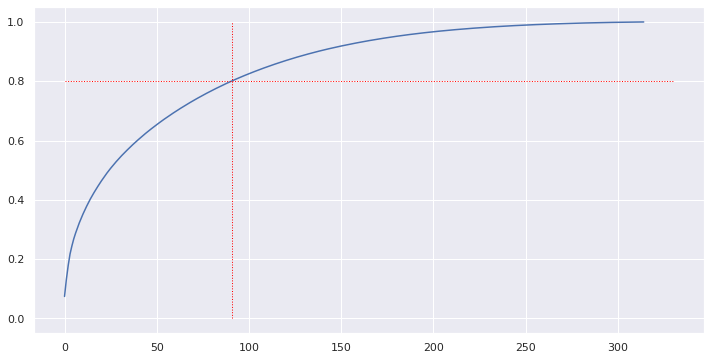

In [89]:
ax = s_copy['pct'].plot(figsize=(12,6))

color ='red'
ax.vlines(idx,0,1, color=color, linestyle='dotted', linewidth=1)
ax.hlines(pct_threshold, 0,330, color=color, linestyle='dotted', linewidth=1)

In [54]:
# looking at top 5 components
n_principal_components = 5

start_idx = N_COMPONENTS - n_principal_components  # 33-n

# print a selection of s
print(s.iloc[start_idx:, :])

              0
310  135.368759
311  130.942535
312  125.924759
313  124.534561
314  119.336052


In [55]:
# print a selection of s
print(s.iloc[:5, :])

             0
0  4378.131836
1  3837.389160
2  3499.068359
3  3164.711670
4  2633.141602


In [56]:
# Calculate the explained variance for the top n principal components
# you may assume you have access to the global var N_COMPONENTS
def explained_variance(s, n_top_components):
    '''Calculates the approx. data variance that n_top_components captures.
       :param s: A dataframe of singular values for top components; 
           the top value is in the last row.
       :param n_top_components: An integer, the number of top components to use.
       :return: The expected data variance covered by the n_top_components.'''
    
    start_idx = N_COMPONENTS - n_top_components  ## 33-3 = 30, for example
    # calculate approx variance
    exp_variance = np.square(s.iloc[start_idx:,:]).sum()/np.square(s).sum()
    
    return exp_variance[0]

In [57]:
# test cell
n_top_components = 7 # select a value for the number of top components

# calculate the explained variance
exp_variance = explained_variance(s, n_top_components)
print('Explained variance: ', exp_variance)

Explained variance:  0.0004637671


In [103]:
# features
df_population_cleaned = pd.read_csv('./data/population_cleaned.csv', nrows=10)
features_list = df_population_cleaned.columns.values
print('Features: \n', features_list)

Features: 
 ['LNR' 'AKT_DAT_KL' 'ANZ_HAUSHALTE_AKTIV' 'ANZ_HH_TITEL' 'ANZ_KINDER'
 'ANZ_PERSONEN' 'ANZ_TITEL' 'ARBEIT' 'BALLRAUM' 'CAMEO_DEUG_2015'
 'CJT_GESAMTTYP' 'CJT_KATALOGNUTZER' 'CJT_TYP_1' 'CJT_TYP_2' 'CJT_TYP_3'
 'CJT_TYP_4' 'CJT_TYP_5' 'CJT_TYP_6' 'D19_BANKEN_ANZ_12'
 'D19_BANKEN_ANZ_24' 'D19_BANKEN_DATUM' 'D19_BANKEN_DIREKT'
 'D19_BANKEN_GROSS' 'D19_BANKEN_LOKAL' 'D19_BANKEN_OFFLINE_DATUM'
 'D19_BANKEN_ONLINE_DATUM' 'D19_BANKEN_REST' 'D19_BEKLEIDUNG_GEH'
 'D19_BEKLEIDUNG_REST' 'D19_BILDUNG' 'D19_BIO_OEKO' 'D19_BUCH_CD'
 'D19_DIGIT_SERV' 'D19_DROGERIEARTIKEL' 'D19_ENERGIE' 'D19_FREIZEIT'
 'D19_GARTEN' 'D19_GESAMT_ANZ_12' 'D19_GESAMT_DATUM'
 'D19_GESAMT_OFFLINE_DATUM' 'D19_GESAMT_ONLINE_DATUM' 'D19_HANDWERK'
 'D19_HAUS_DEKO' 'D19_KINDERARTIKEL' 'D19_KONSUMTYP_MAX' 'D19_KOSMETIK'
 'D19_LEBENSMITTEL' 'D19_NAHRUNGSERGAENZUNG' 'D19_RATGEBER' 'D19_REISEN'
 'D19_SAMMELARTIKEL' 'D19_SCHUHE' 'D19_SONSTIGE' 'D19_TECHNIK'
 'D19_TELKO_ANZ_12' 'D19_TELKO_ANZ_24' 'D19_TELKO_DATUM'
 'D19_TE

### Component Makeup
We can now examine the makeup of each PCA component based on the weightings of the original features that are included in the component. The following code shows the feature-level makeup of the first component.

Note that the components are again ordered from smallest to largest and so I am getting the correct rows by calling N_COMPONENTS-1 to get the top, 1, component.

In [104]:
s

,0
0,4378.131836
1,3837.389160
2,3499.068359
3,3164.711670
4,2633.141602
...,...
310,135.368759
311,130.942535
312,125.924759
313,124.534561


In [105]:
v

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314
0,-0.029595,0.092759,-0.058283,0.045104,-0.090814,0.035113,0.023270,-0.055458,0.076765,-0.033259,0.008088,-0.024991,0.042898,-0.004201,0.110997,-0.079967,0.057735,-0.005044,-0.002732,-0.050572,0.083667,-0.053912,0.007594,-0.001528,0.147726,...,-0.003509,0.008445,0.037922,0.021598,0.038035,0.003169,-0.056135,-0.047593,0.037641,0.035506,0.004774,0.014648,0.016574,-0.014015,-0.023491,0.018344,0.007949,0.005724,0.015202,-0.035509,-0.015366,0.035171,-0.022111,0.029997,-0.001275
1,0.061665,0.035159,-0.005004,0.056500,0.005297,0.012174,0.005032,0.031373,0.045900,0.078555,-0.042454,0.057967,0.018173,-0.008671,0.030795,0.039194,0.048771,0.011449,-0.048944,0.011313,-0.009739,-0.075874,-0.006584,-0.106802,-0.039797,...,-0.015024,-0.011357,-0.003413,0.013160,0.009072,-0.021042,-0.016046,-0.029603,0.020683,-0.059276,0.051450,0.049771,-0.010123,-0.038415,0.006565,0.008953,0.022401,-0.035892,0.027668,0.027076,-0.008419,-0.006101,-0.008407,0.004290,-0.042827
2,0.068484,0.023176,0.008869,-0.067160,0.030989,0.000065,-0.017507,-0.008982,0.060373,0.041204,-0.079158,0.068585,0.001051,0.007985,-0.061759,0.021611,-0.092933,0.007613,-0.138092,-0.057092,0.045820,0.068618,0.071955,0.047375,0.054964,...,0.014572,0.089784,0.014562,0.006089,-0.026186,0.000432,-0.005515,-0.003357,-0.048206,-0.003278,0.002244,-0.036944,-0.013611,0.027983,0.048358,0.035068,0.010888,0.034985,-0.049708,-0.032566,0.042594,0.012097,-0.021792,-0.009711,-0.038742
3,0.013268,0.013880,-0.004572,-0.015529,0.018898,0.000278,-0.026181,0.020392,-0.004927,0.018239,-0.070787,0.053300,-0.019735,-0.021131,-0.020136,0.012636,-0.070070,0.003875,0.000048,-0.066380,0.045814,0.050841,0.062655,-0.013533,0.112919,...,0.001635,-0.022571,-0.012884,-0.004867,0.000668,0.042891,0.009389,-0.002723,0.019694,0.009657,0.002666,-0.020081,-0.020528,-0.016885,-0.044567,-0.035822,-0.013972,-0.000216,0.033076,-0.002625,-0.011525,-0.013706,0.021350,0.000650,0.029575
4,-0.051683,0.029685,0.058590,-0.003775,0.005904,0.017959,-0.040023,0.016214,0.015975,0.010112,-0.028769,-0.019906,-0.043327,0.016919,-0.120131,0.055624,0.132061,-0.003095,-0.010988,-0.161645,0.025262,-0.031729,0.185569,-0.152719,0.034453,...,-0.012603,0.095034,-0.100749,-0.076864,0.072879,-0.039022,0.015849,-0.088110,0.001576,0.177065,-0.094223,0.064375,0.075716,-0.113834,-0.048794,-0.117419,-0.097407,-0.043087,0.064391,0.047077,0.070110,-0.035630,0.053265,0.050121,-0.027896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,0.078525,0.031970,0.029783,0.040124,0.003948,-0.051317,-0.049785,-0.002832,0.048207,0.108090,-0.021277,-0.012262,-0.009510,-0.000678,0.089651,-0.013508,0.050462,0.011460,0.036057,-0.022538,0.044497,0.023051,-0.000056,-0.001634,0.004172,...,-0.049435,0.018118,-0.056082,0.027493,-0.014363,0.007470,0.034361,-0.015708,-0.019209,-0.040151,-0.019936,0.006724,-0.013198,0.012655,0.014462,-0.030363,-0.000156,-0.032210,-0.021804,0.020699,0.010094,0.000468,-0.017347,0.001207,0.007999
312,-0.008304,0.008946,-0.018034,0.017755,-0.111842,-0.316677,-0.063133,0.019177,-0.028677,0.040168,-0.007751,0.007894,0.023429,0.020579,-0.013642,-0.023037,-0.007638,-0.005071,-0.001541,-0.028646,-0.002222,-0.049845,-0.023969,-0.012738,-0.000933,...,-0.110612,-0.009555,0.129185,-0.059772,0.054921,0.017861,-0.054472,0.095045,-0.002894,-0.094104,-0.022873,-0.006775,-0.017652,-0.008954,-0.080132,-0.063310,0.046186,-0.002346,0.173027,0.037583,0.064178,0.008257,-0.150513,0.022050,0.041445
313,-0.027834,-0.119227,-0.139966,-0.105422,-0.045591,0.002516,-0.064066,-0.025075,0.054249,0.034477,-0.014393,-0.041254,-0.020253,0.037846,0.043668,0.071055,0.027192,-0.027684,-0.014313,0.025193,-0.021006,0.037141,0.040823,-0.034970,0.014145,...,-0.01772

In [106]:
import seaborn as sns

def display_component(v, features_list, component_num, n_weights=10):
    
    # get index of component 
    row_idx = component_num -1 

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values)

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()
    


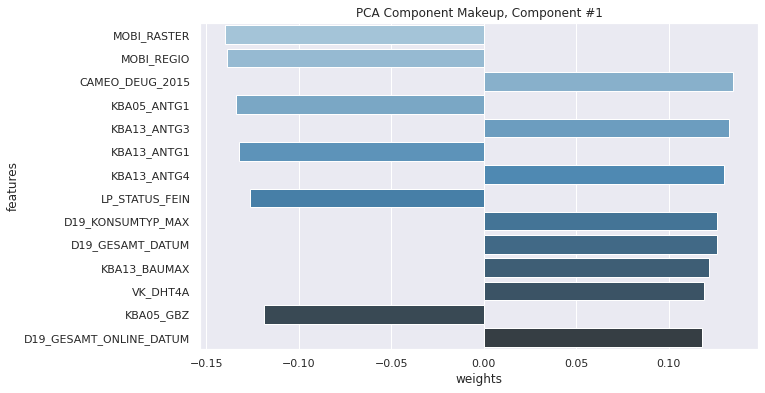

In [107]:
# display makeup of first component
num=1
display_component(v, features_list, component_num=num, n_weights=14)

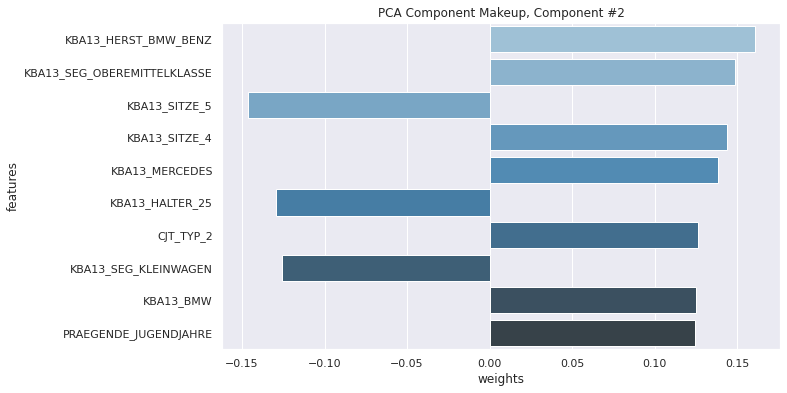

In [108]:
# display makeup of first component
num=2
display_component(v, features_list, component_num=num, n_weights=10)

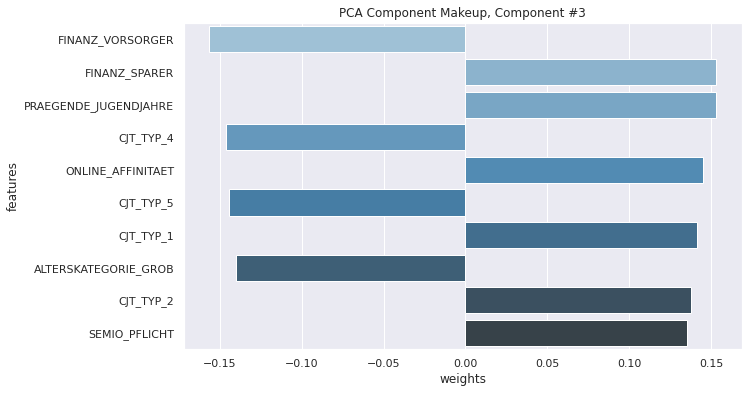

In [109]:
# display makeup of first component
num=3
display_component(v, features_list, component_num=num, n_weights=10)

### Apply PCA on reduced components

In [117]:
# must be less than dim of feature - therefore the maximum is: training_features.shape[1] -1 
N_COMPONENTS = np.argmax(s_copy['pct']>pct_threshold)
#s3://sagemaker-us-east-1-675510605794/sagemaker-scikit-learn-2021-12-27-09-21-02-837/output/train_data
sess = sagemaker.Session()

pca = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count    = 1,
    instance_type     = "ml.c4.xlarge",    
    output_path       = output_location,
    sagemaker_session = sess,
)
pca.set_hyperparameters(
    feature_dim=training_features.shape[1],
    num_components=N_COMPONENTS,
    subtract_mean=True,
    algorithm_mode="randomized",
    mini_batch_size=500,
)


pca_fit_result = pca.fit({"train": pca_train_input})

2021-12-27 15:36:16 Starting - Starting the training job...
2021-12-27 15:36:39 Starting - Launching requested ML instancesProfilerReport-1640619375: InProgress
......
2021-12-27 15:37:39 Starting - Preparing the instances for training............
2021-12-27 15:39:40 Downloading - Downloading input data
2021-12-27 15:39:40 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/27/2021 15:40:00 INFO 140719026198336] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'algorithm_mode': 'regular', 'subtract_mean': 'true', 'extra_components': '-1', 'force_dense': 'true', 'epochs': 1, '_log_level': 'info', '_kvstore': 'dist_sync', '_num_kv_servers': 'auto', '_num_gpus': 'auto'}
[12/27/2021 15:40:00 INFO 140719026198336] Merging with provided configuration from /opt/ml/input/config/hyperparameters.json: {'feature_dim': '316', 'algorithm_mode

### Access Model Parameters

In [120]:
import mxnet as mx
import os

# Get the name of the training job, it's suggested that you copy-paste
# from the notebook or from a specific job in the AWS console
training_job_name='pca-2021-12-27-15-36-15-653'

# where the model is saved, by default
model_key = os.path.join(prefix, 'output', training_job_name, 'output/model.tar.gz')
print(model_key)

# download and unzip model
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')

# unzipping as model_algo-1
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')



# loading the unzipped artifacts
pca_model_params = mx.ndarray.load('model_algo-1')

# get selected params
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

ml-segmentation-arvato/output/pca-2021-12-27-15-36-15-653/output/model.tar.gz


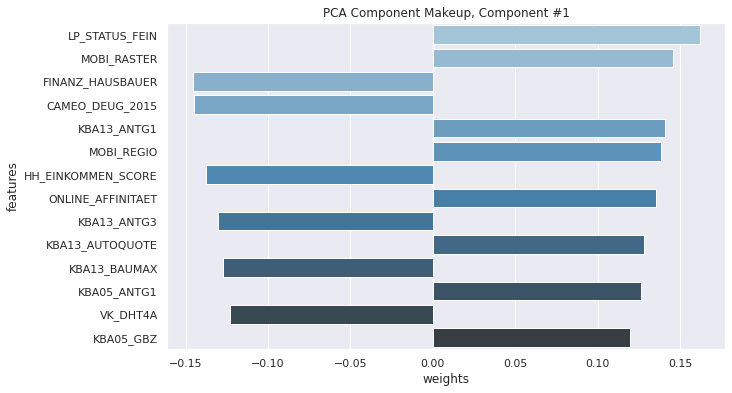

In [121]:
# display makeup of first component
num=1
display_component(v, features_list, component_num=num, n_weights=14)

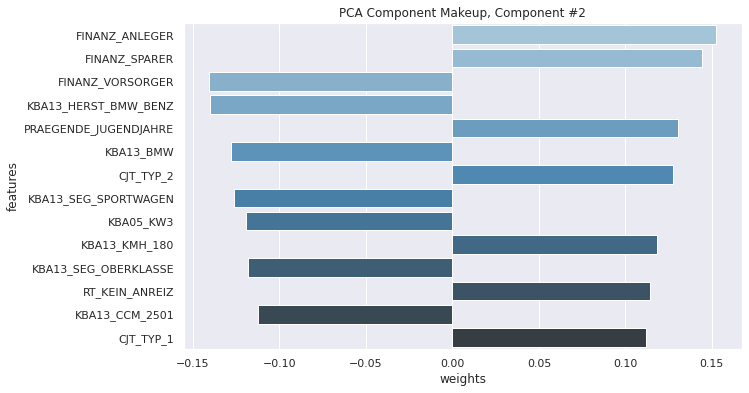

In [122]:
# display makeup of first component
num=2
display_component(v, features_list, component_num=num, n_weights=14)

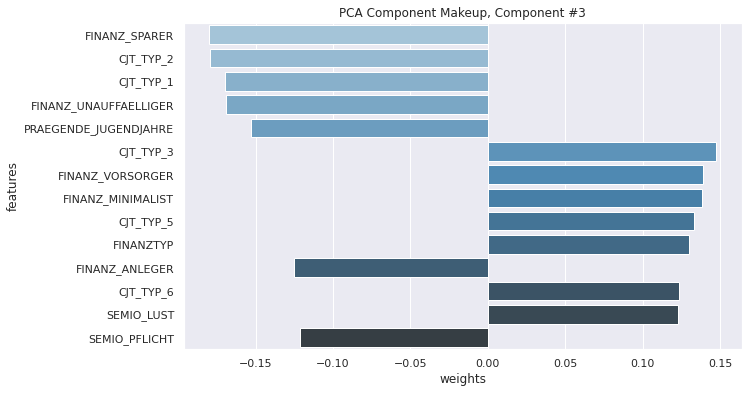

In [123]:
# display makeup of first component
num=3
display_component(v, features_list, component_num=num, n_weights=14)

### Prepare Customer Data

In [125]:
%%writefile preprocessing_custscript.py

import argparse
import os
import warnings
import boto3

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import make_column_transformer

from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings(action="ignore", category=DataConversionWarning)


def scale_and_impute(X_train):
    """
    Description
    -----------
        this method scales data to [0,1] and imputes missing values


     Return
    ------
        pd.DataFrame : result scale and impute method
    """
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    scaler  = StandardScaler()
    
    col_names = X_train.columns
    index = X_train.index

    # scale
    print('Scaling dataset')
    df = scaler.fit_transform(X_train)
    # impute
    print('Imputing missing values')
    df = pd.DataFrame(imputer.fit_transform(df))

    df.set_index(index, inplace=True)
    df.columns = col_names
    
    print('Scale and Impute transformation completed.')

    return df

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    
    #parser.add_argument("--n_pca_components", type=int, default=10)
    args, _ = parser.parse_known_args()

    print("Received arguments {}".format(args))

    customers_input_data_path = os.path.join("/opt/ml/processing/input", "customers_cleaned.csv")
    #customers_input_data_path = os.path.join("/opt/ml/processing/input2", "customers_cleaned.csv")

    print("Reading input data from {}".format(customers_input_data_path))    
    df_customers = pd.read_csv(customers_input_data_path)    
    print("Running preprocessing transformations for customers data")
    df_customers = scale_and_impute(df_customers)
    
    #print("Reading input data from {}".format(customers_input_data_path))
    #df_customers = pd.read_csv(customers_input_data_path)    
    #print("Running preprocessing transformations for customers data")
    #df_customers = scale_and_impute(df_customers)


    print("customers data shape after preprocessing: {}".format(df_customers.shape))
    #print("Customers data shape after preprocessing: {}".format(df_customers.shape))

    train_customers_output_path = os.path.join("/opt/ml/processing/train", "train_customers.csv")
    #train_customers_output_path = os.path.join("/opt/ml/processing/train", "train_customers.csv")

    print("Saving training features to {}".format(train_customers_output_path))
    pd.DataFrame(df_customers).to_csv(train_customers_output_path, header=False, index=False)
    
    #print("Saving test features to {}".format(train_customers_output_path))
    #pd.DataFrame(df_customers).to_csv(train_customers_output_path, header=False, index=False)


Writing preprocessing_custscript.py


In [126]:
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.sklearn.processing import SKLearnProcessor

train_input_customers = 's3://sagemaker-us-east-1-675510605794/ml-segmentation-arvato/train/customers_cleaned.csv'
#= 's3://sagemaker-us-east-1-675510605794/ml-segmentation-arvato/train/customers_cleaned.csv'

sklearn_processor = SKLearnProcessor(
    framework_version="0.20.0", role=role, instance_type="ml.m5.xlarge", instance_count=1
)

sklearn_processor.run(
    code="preprocessing_custscript.py",
    inputs=[ProcessingInput(source=train_input_customers, destination="/opt/ml/processing/input")],
    outputs=[
        ProcessingOutput(output_name="train_data", source="/opt/ml/processing/train")
        #ProcessingOutput(output_name="test_data", source="/opt/ml/processing/test"),
    ]
)

preprocessing_job_description = sklearn_processor.jobs[-1].describe()

output_config = preprocessing_job_description["ProcessingOutputConfig"]
for output in output_config["Outputs"]:
    if output["OutputName"] == "train_data":
        preprocessed_training_data = output["S3Output"]["S3Uri"]
    if output["OutputName"] == "test_data":
        preprocessed_test_data = output["S3Output"]["S3Uri"]


Job Name:  sagemaker-scikit-learn-2021-12-27-16-00-41-429
Inputs:  [{'InputName': 'input-1', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-675510605794/ml-segmentation-arvato/train/customers_cleaned.csv', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-675510605794/sagemaker-scikit-learn-2021-12-27-16-00-41-429/input/code/preprocessing_custscript.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'train_data', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-675510605794/sagemaker-scikit-learn-2021-12-27-16-00-41-429/output/train_data', 'LocalPath': '/opt/ml/processing/train', 'S3UploadMode'